#  Adversarial training


In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
from os.path import join,exists

import time 
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import copy

import tensorflow as tf
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model

from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack

from adv_benchmark.config import Config
from adv_benchmark.models_training import pick_data_set,train_and_save_effnet,train_and_save_small_model
from adv_benchmark.white_box_attacks import three_attacks_runner
from adv_benchmark.black_box_attacks import boundary_attack_run
from adv_benchmark.adversarial_training import train_models

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

tf.config.run_functions_eagerly(False)
tf.random.set_seed(0)

#### 2. Load models

On défini une classe qui créé des modèles dont la fonction objectif est une combinaison de deux fonction objectifs. La première est une cross-entropie classique et la seconde est une cross-entropie adverse. C'est à dire une fonction qui vise à correctement classifier un exemple adverse 

$$J_{tot}(\theta,x,y)=(1-c)J(\theta,x,y)+cJ(\theta,(x+{\epsilon}sign(\nabla_{x}J(\theta,x,y)),y)$$ 

In [3]:
def attacks(data_set_list=['Mnist','Cifar']):
    data_set_plots={}
    model=train_models()
    for data_set_name in data_set_list:
        (_,X_test,_,y_test)=pick_data_set(data_set_name)        
        plots={}
        epsilons=[0.1,1,5,10,25,50,75,100]
        X=X_test[7000:7100]
        y=y_test[7000:7100]
        for c in [0,0.1,0.3,0.5,0.7,0.9]:
            print("======= attack: data_set: "+str(data_set_name)+' c:'+str(c)+'======')
            model.load_weights(Config.MODELS_PATH+'/adversarial_training/'+str(data_set_name)+'/c='+str(c)+'.h5')
            if exists(Config.DATA_PATH+'efficiency_adv_trained/'+str(data_set_name)+'/c='+str(c))==False:
                plots[c],_=attack_runner(model,model,X, y, epsilons)
                with open(Config.DATA_PATH+'efficiency_adv_trained/'+str(data_set_name)+'/c='+str(c), 'wb') as f:
                        pickle.Pickler(f).dump(plots[c])

            else:
                with open(Config.DATA_PATH+'efficiency_adv_trained/'+str(data_set_name)+'/c='+str(c), 'rb') as f:
                    plots[c]=pickle.Unpickler(f).load()
        data_set_plots[data_set_name]=plots
    return(data_set_plots)
        
    

In [4]:
data_set_plots=attacks(data_set_list=['Mnist','Cifar'])

======= training on data_set: Cifar c:0======
-----------
Accuracy is 0.327 
======= training on data_set: Cifar c:0.1======
-----------
Accuracy is 0.715 
======= training on data_set: Cifar c:0.3======
-----------
Accuracy is 0.75 
======= training on data_set: Cifar c:0.5======
-----------
Accuracy is 0.818 
======= training on data_set: Cifar c:0.7======
-----------
Accuracy is 0.808 
======= training on data_set: Cifar c:0.9======
-----------
Accuracy is 0.805 
======= training on data_set: Mnist c:0======
-----------
Accuracy is 0.982 
======= training on data_set: Mnist c:0.1======
-----------
Accuracy is 0.986 
======= training on data_set: Mnist c:0.3======
-----------
Accuracy is 0.984 
======= training on data_set: Mnist c:0.5======
-----------
Accuracy is 0.992 
======= training on data_set: Mnist c:0.7======
-----------
Accuracy is 0.985 
======= training on data_set: Mnist c:0.9======
-----------
Accuracy is 0.983 
======= attack: data_set: Mnist c:0======
======= attack:

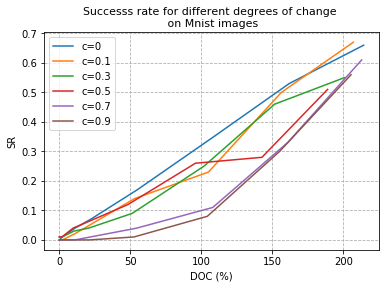

In [5]:
for c,plot in data_set_plots['Mnist'].items():
    plt.plot(list(plot.keys()),list(plot.values()),label='c='+str(c))
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')

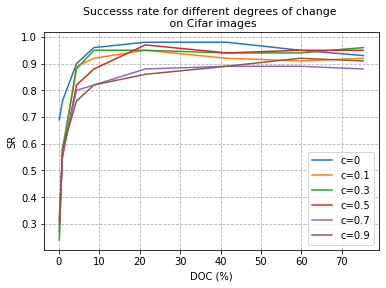

In [6]:
for c,plot in data_set_plots['Cifar'].items():
    plt.plot(list(plot.keys()),list(plot.values()),label='c='+str(c))
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Cifar images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='lower right')

Clearly the adversarial training has decreased the efficiency of the attacks so it is truly beneficial. It seems that the higher c is and the better the protection

Let's save the 'best model' --> c=0.9

### Softmax probabilities visualizations

At first let's create some adversarial examples that will fool the most basic model

In [8]:
model=train_models()

======= training on data_set: Cifar c:0======
-----------
Accuracy is 0.327 
======= training on data_set: Cifar c:0.1======
-----------
Accuracy is 0.715 
======= training on data_set: Cifar c:0.3======
-----------
Accuracy is 0.75 
======= training on data_set: Cifar c:0.5======
-----------
Accuracy is 0.818 
======= training on data_set: Cifar c:0.7======
-----------
Accuracy is 0.808 
======= training on data_set: Cifar c:0.9======
-----------
Accuracy is 0.805 
======= training on data_set: Mnist c:0======
-----------
Accuracy is 0.982 
======= training on data_set: Mnist c:0.1======
-----------
Accuracy is 0.986 
======= training on data_set: Mnist c:0.3======
-----------
Accuracy is 0.984 
======= training on data_set: Mnist c:0.5======
-----------
Accuracy is 0.992 
======= training on data_set: Mnist c:0.7======
-----------
Accuracy is 0.985 
======= training on data_set: Mnist c:0.9======
-----------
Accuracy is 0.983 


In [27]:
model.load_weights(Config.MODELS_PATH+'/adversarial_training/Cifar/c=0.h5')
(_,X_test,_,y_test)=pick_data_set('Cifar')
model_to_attack=TensorFlowModel(model , bounds=(0, 255))
attack=LinfFastGradientAttack()
image_list=X_test[:100]
labels=list(map(np.argmax,y_test[:100]))
adv_list=[]
true_label=[]
for i,image in enumerate(tqdm(image_list,position=0)):
    image = np.asarray(image)[:,:,:3].astype('float32')
    image = convert_to_tensor(np.expand_dims(image,axis=0))
    label=labels[i]
    label = tf.convert_to_tensor(np.array([label]))
    _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=5)
    if bool(is_adv[0])==True:
        adv_list.append(np.array(clipped[0]))
        true_label.append(labels[i])
    

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Let's visualize the outputs of the softmax layers of the different models when given the adversarial images 

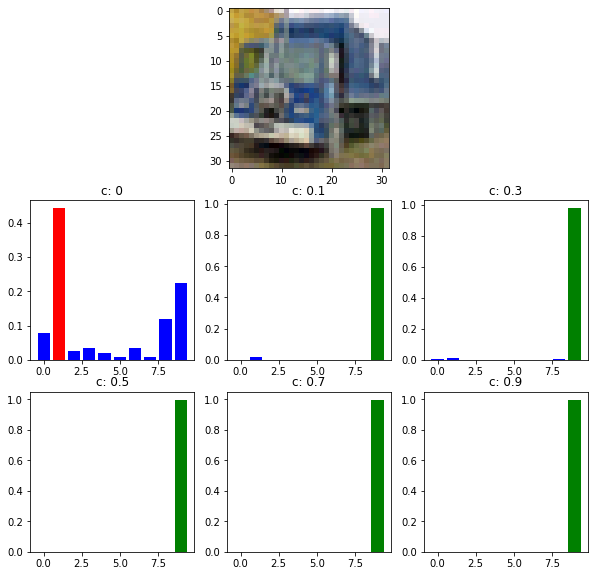

In [28]:
adv_image_num=9

plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]): 
    model.load_weights(Config.MODELS_PATH+'adversarial_training/Cifar/c='+str(c)+'.h5')
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=model.predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))


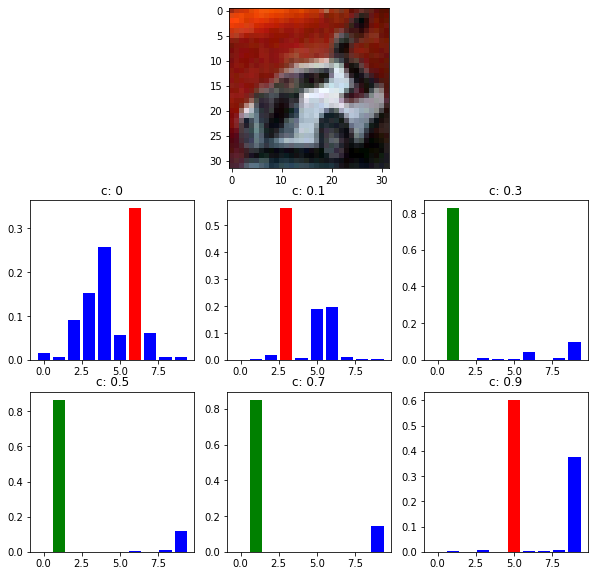

In [30]:
adv_image_num=2


plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]):
    model.load_weights(Config.MODELS_PATH+'adversarial_training/Cifar/c='+str(c)+'.h5')
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=model.predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))

### Against a black box attack (boundary attack)

In [3]:
model=train_models()

======= training on data_set: Cifar c:0======
-----------
Accuracy is 0.327 
======= training on data_set: Cifar c:0.1======
-----------
Accuracy is 0.715 
======= training on data_set: Cifar c:0.3======
-----------
Accuracy is 0.75 
======= training on data_set: Cifar c:0.5======
-----------
Accuracy is 0.818 
======= training on data_set: Cifar c:0.7======
-----------
Accuracy is 0.808 
======= training on data_set: Cifar c:0.9======
-----------
Accuracy is 0.805 
======= training on data_set: Mnist c:0======
-----------
Accuracy is 0.982 
======= training on data_set: Mnist c:0.1======
-----------
Accuracy is 0.986 
======= training on data_set: Mnist c:0.3======
-----------
Accuracy is 0.984 
======= training on data_set: Mnist c:0.5======
-----------
Accuracy is 0.992 
======= training on data_set: Mnist c:0.7======
-----------
Accuracy is 0.985 
======= training on data_set: Mnist c:0.9======
-----------
Accuracy is 0.983 


#### Mnist



Adversarial image at step 0. L2 error 7993.733040065383 and class label 6.


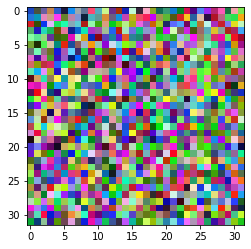



Adversarial image at step 1. L2 error 7913.7957158962645 and class label 6.


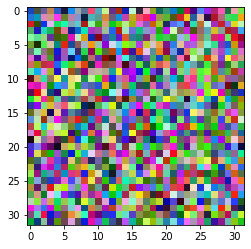



Adversarial image at step 2. L2 error 7795.148112115151 and class label 6.


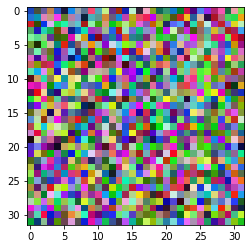



Adversarial image at step 3. L2 error 7619.932535828638 and class label 6.


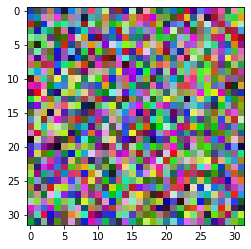



Adversarial image at step 4. L2 error 7363.145169162789 and class label 6.


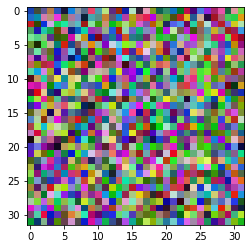



Adversarial image at step 5. L2 error 6991.130399502432 and class label 6.


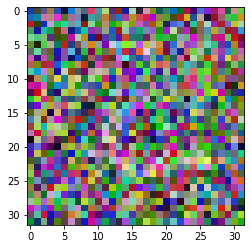



Adversarial image at step 6. L2 error 6461.566630118299 and class label 6.


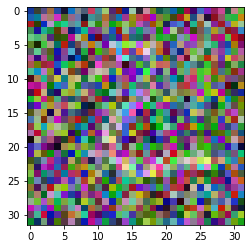



Adversarial image at step 7. L2 error 5727.757431217076 and class label 6.


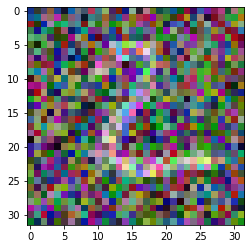



Adversarial image at step 8. L2 error 5077.282467464875 and class label 6.


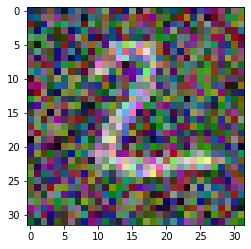



Adversarial image at step 9. L2 error 4963.1535249541175 and class label 6.


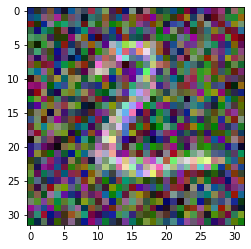



Adversarial image at step 10. L2 error 4930.028814258841 and class label 6.


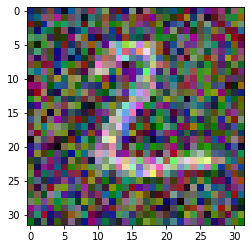



Adversarial image at step 11. L2 error 4897.128124650383 and class label 6.


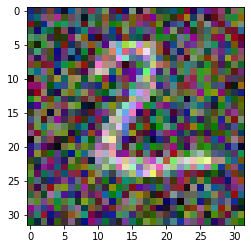



Adversarial image at step 12. L2 error 4864.446745770689 and class label 6.


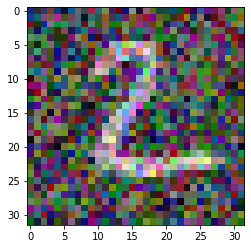



Adversarial image at step 13. L2 error 4815.695017729603 and class label 6.


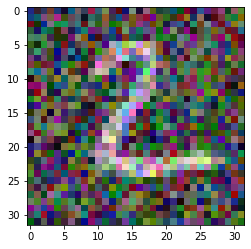



Adversarial image at step 14. L2 error 4767.413098383648 and class label 6.


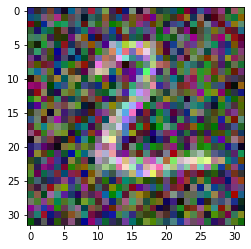



Adversarial image at step 15. L2 error 4695.50192093687 and class label 6.


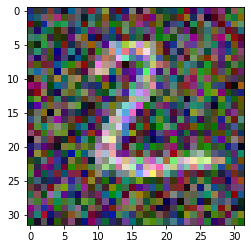



Adversarial image at step 16. L2 error 4588.619014865418 and class label 6.


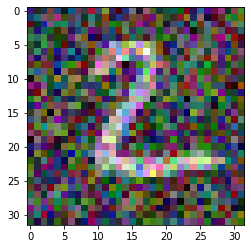



Adversarial image at step 17. L2 error 4518.588815431831 and class label 6.


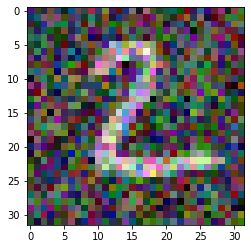



Adversarial image at step 18. L2 error 4413.606507976885 and class label 6.


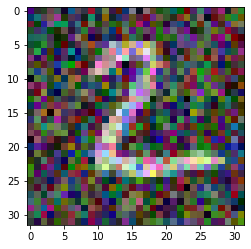



Adversarial image at step 19. L2 error 4260.896013337724 and class label 6.


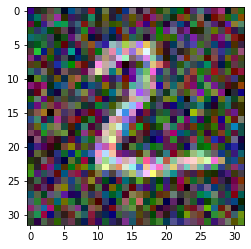



Adversarial image at step 20. L2 error 4113.6673158501935 and class label 6.


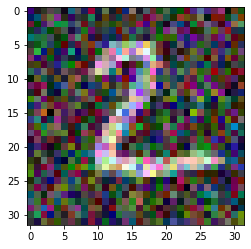



Adversarial image at step 21. L2 error 4017.2320471789712 and class label 6.


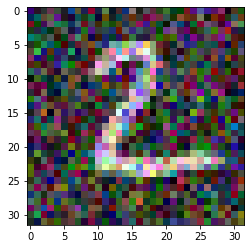



Adversarial image at step 22. L2 error 3923.0498137236864 and class label 6.


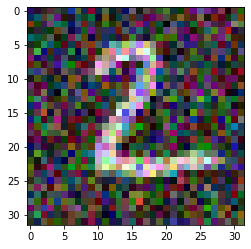



Adversarial image at step 23. L2 error 3831.016243296409 and class label 6.


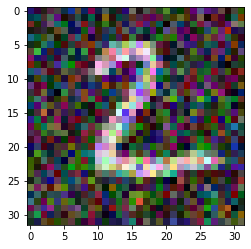



Adversarial image at step 24. L2 error 3700.419437719634 and class label 6.


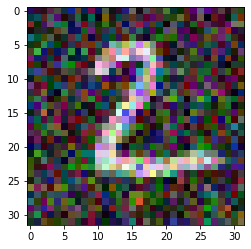



Adversarial image at step 25. L2 error 3643.4643296642007 and class label 6.


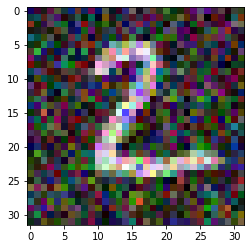



Adversarial image at step 26. L2 error 3606.6053698165406 and class label 6.


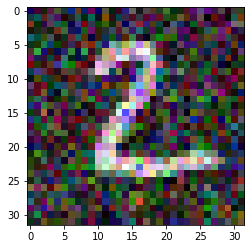



Adversarial image at step 27. L2 error 3570.0151917893804 and class label 6.


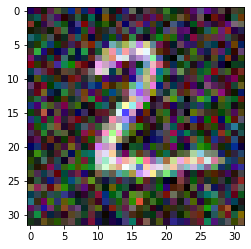



Adversarial image at step 28. L2 error 3515.999776449089 and class label 6.


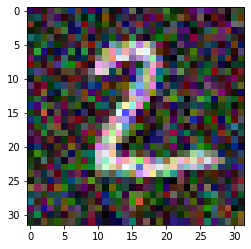



Adversarial image at step 29. L2 error 3435.6737793964767 and class label 6.


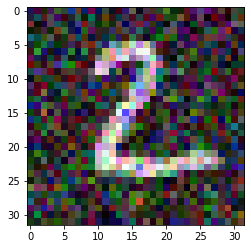



Adversarial image at step 30. L2 error 3357.976867804973 and class label 6.


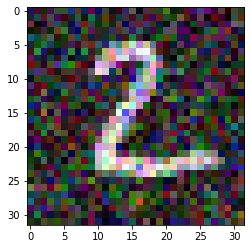



Adversarial image at step 31. L2 error 3324.0027361220064 and class label 6.


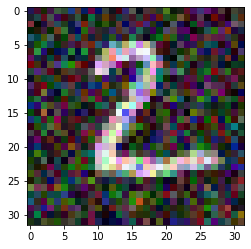



Adversarial image at step 32. L2 error 3290.2020380254453 and class label 6.


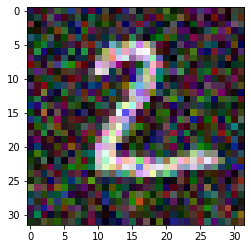



Adversarial image at step 33. L2 error 3256.7562489808306 and class label 6.


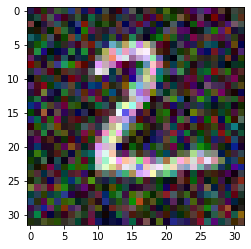



Adversarial image at step 34. L2 error 3207.462671765008 and class label 6.


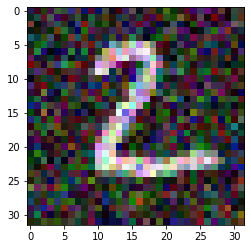



Adversarial image at step 35. L2 error 3174.0381831043733 and class label 6.


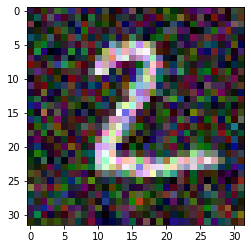



Adversarial image at step 36. L2 error 3123.0208317969673 and class label 6.


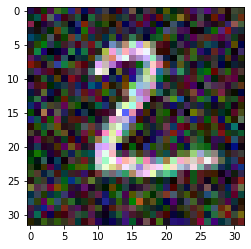



Adversarial image at step 37. L2 error 3050.939907251974 and class label 6.


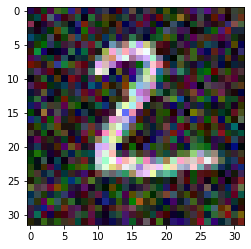



Adversarial image at step 38. L2 error 3029.2857833796047 and class label 6.


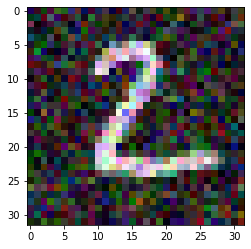



Adversarial image at step 39. L2 error 3008.3763643032767 and class label 6.


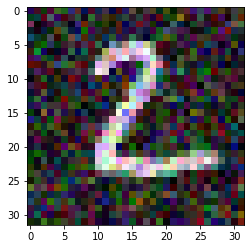



Adversarial image at step 40. L2 error 2994.3317901592113 and class label 6.


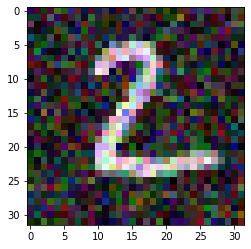



Adversarial image at step 41. L2 error 2973.793654949721 and class label 6.


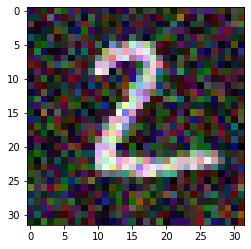



Adversarial image at step 42. L2 error 2943.5657982818634 and class label 6.


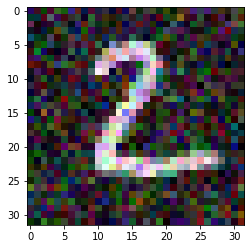



Adversarial image at step 43. L2 error 2899.208709663043 and class label 6.


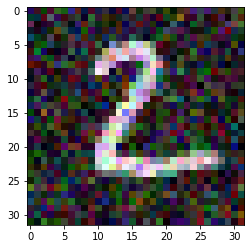



Adversarial image at step 44. L2 error 2886.1070310041537 and class label 6.


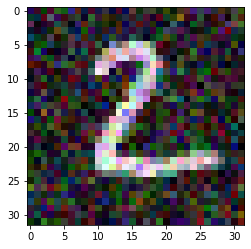



Adversarial image at step 45. L2 error 2873.1960176234056 and class label 6.


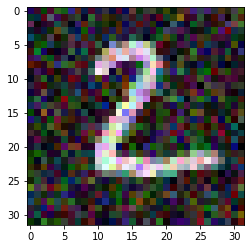



Adversarial image at step 46. L2 error 2860.3803522360035 and class label 6.


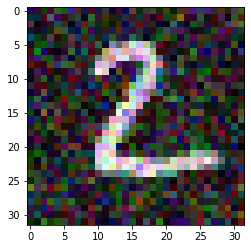



Adversarial image at step 47. L2 error 2841.2528082559775 and class label 6.


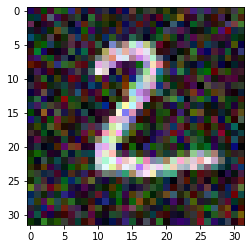



Adversarial image at step 48. L2 error 2822.1829658296415 and class label 6.


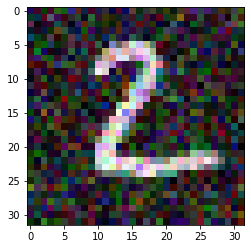



Adversarial image at step 49. L2 error 2803.1687495441806 and class label 6.


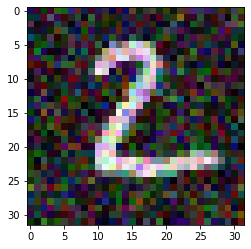



Adversarial image at step 50. L2 error 2775.0694127437237 and class label 6.


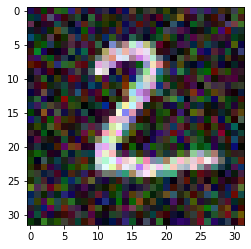



Adversarial image at step 51. L2 error 2756.5193570334627 and class label 6.


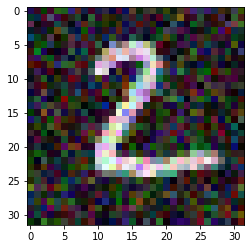



Adversarial image at step 52. L2 error 2737.999887419751 and class label 6.


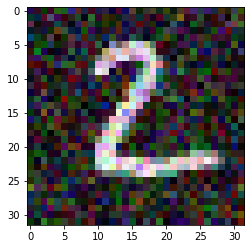



Adversarial image at step 53. L2 error 2719.6205659165735 and class label 6.


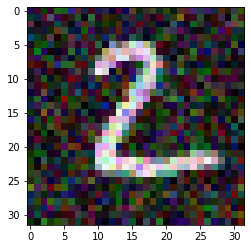



Adversarial image at step 54. L2 error 2701.3772670984295 and class label 6.


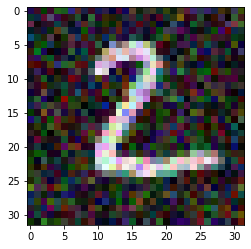



Adversarial image at step 55. L2 error 2693.2547294457663 and class label 6.


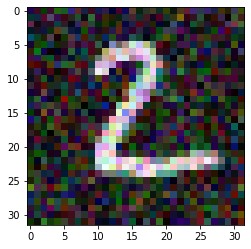



Adversarial image at step 56. L2 error 2685.2010252990367 and class label 6.


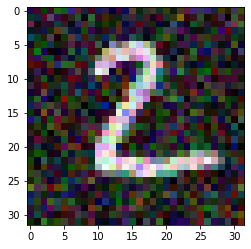



Adversarial image at step 57. L2 error 2673.2116295749643 and class label 6.


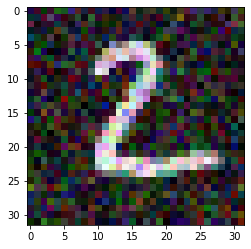



Adversarial image at step 58. L2 error 2670.750852613659 and class label 6.


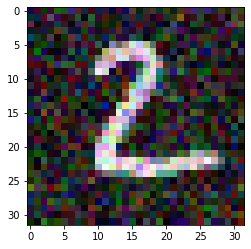



Adversarial image at step 59. L2 error 2668.363054008837 and class label 6.


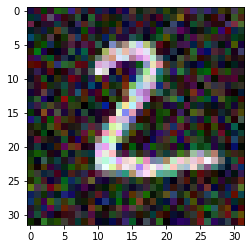



Adversarial image at step 60. L2 error 2664.804968512572 and class label 6.


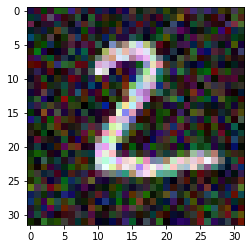



Adversarial image at step 61. L2 error 2659.4511443887427 and class label 6.


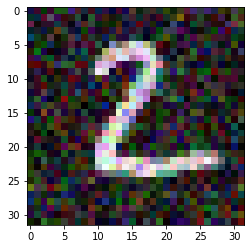



Adversarial image at step 62. L2 error 2651.4353575620717 and class label 6.


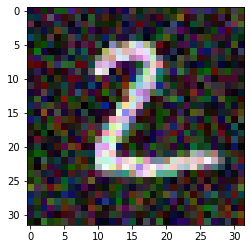



Adversarial image at step 63. L2 error 2639.5255518814047 and class label 6.


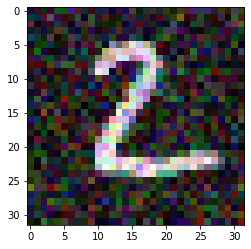



Adversarial image at step 64. L2 error 2621.6138854689857 and class label 6.


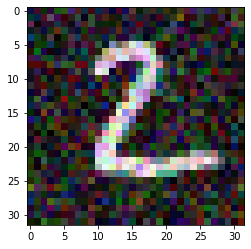



Adversarial image at step 65. L2 error 2595.2673077156487 and class label 6.


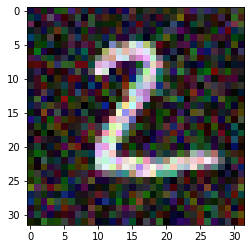



Adversarial image at step 66. L2 error 2569.1776755505025 and class label 6.


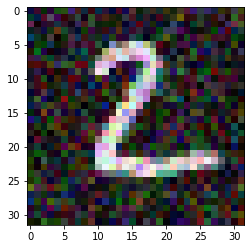



Adversarial image at step 67. L2 error 2557.5728932697643 and class label 6.


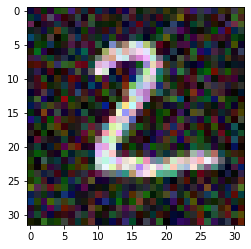



Adversarial image at step 68. L2 error 2545.984482485961 and class label 6.


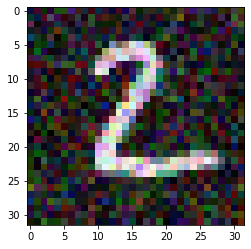



Adversarial image at step 69. L2 error 2542.5268164236595 and class label 6.


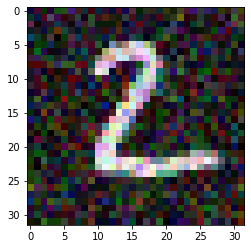



Adversarial image at step 70. L2 error 2539.085588627049 and class label 6.


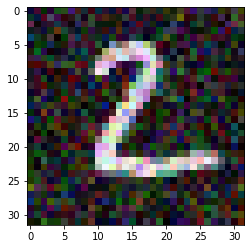



Adversarial image at step 71. L2 error 2534.026095151132 and class label 6.


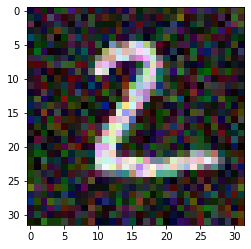



Adversarial image at step 72. L2 error 2526.455104079159 and class label 6.


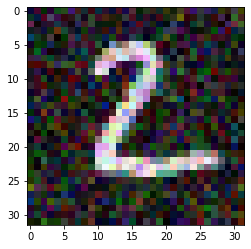



Adversarial image at step 73. L2 error 2515.158452191087 and class label 6.


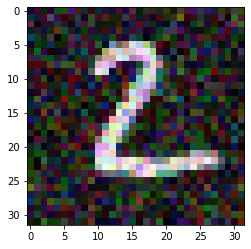



Adversarial image at step 74. L2 error 2503.8858736757315 and class label 6.


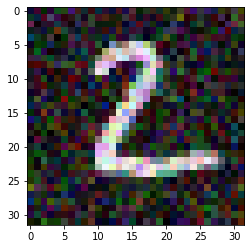



Adversarial image at step 75. L2 error 2492.636741413925 and class label 6.


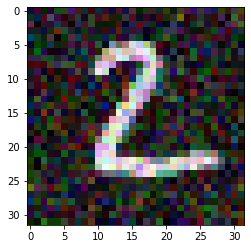



Adversarial image at step 76. L2 error 2481.46463562085 and class label 6.


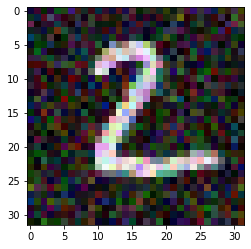



Adversarial image at step 77. L2 error 2464.8613756344503 and class label 6.


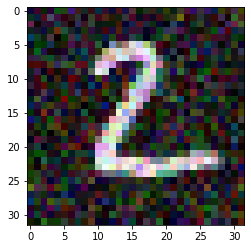



Adversarial image at step 78. L2 error 2448.3732074169397 and class label 6.


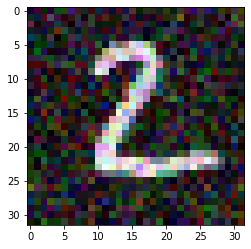



Adversarial image at step 79. L2 error 2432.0065415132167 and class label 6.


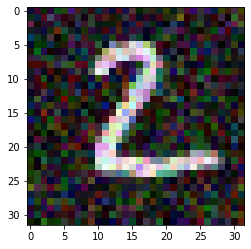



Adversarial image at step 80. L2 error 2428.7677827623697 and class label 6.


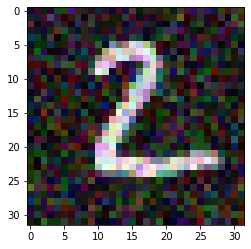



Adversarial image at step 81. L2 error 2423.9429191975673 and class label 6.


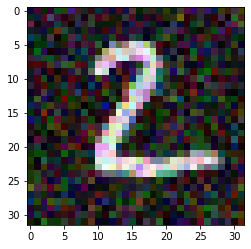



Adversarial image at step 82. L2 error 2416.739650978061 and class label 6.


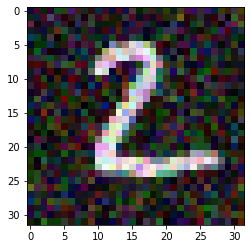



Adversarial image at step 83. L2 error 2409.5648762348474 and class label 6.


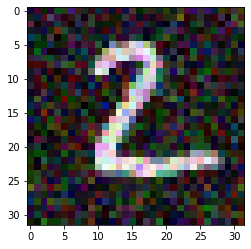



Adversarial image at step 84. L2 error 2398.825729673006 and class label 6.


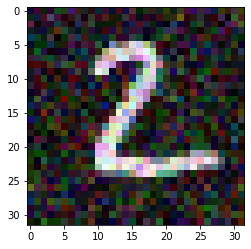



Adversarial image at step 85. L2 error 2382.8005659197556 and class label 6.


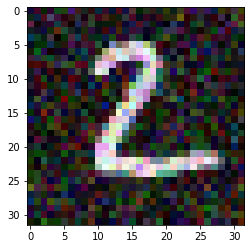



Adversarial image at step 86. L2 error 2375.6977355794775 and class label 6.


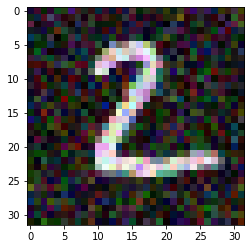



Adversarial image at step 87. L2 error 2368.6037123514243 and class label 6.


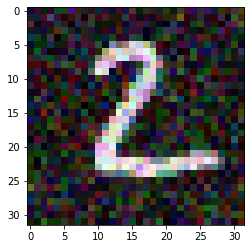



Adversarial image at step 88. L2 error 2363.836788408984 and class label 6.


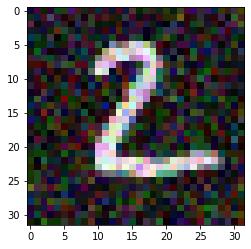



Adversarial image at step 89. L2 error 2356.8121258182764 and class label 6.


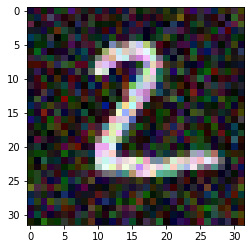



Adversarial image at step 90. L2 error 2349.803475948695 and class label 6.


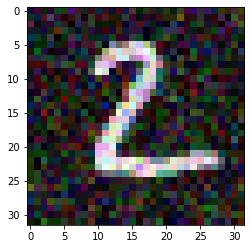



Adversarial image at step 91. L2 error 2339.338297126525 and class label 6.


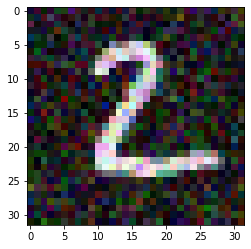



Adversarial image at step 92. L2 error 2328.884419261434 and class label 6.


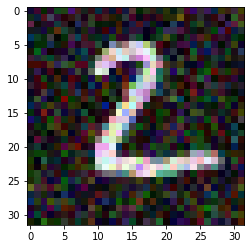



Adversarial image at step 93. L2 error 2318.427958026494 and class label 6.


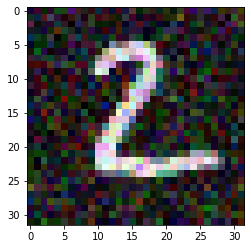



Adversarial image at step 94. L2 error 2311.497001039355 and class label 6.


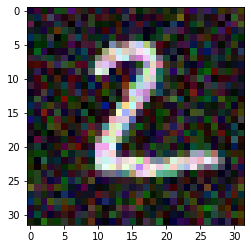



Adversarial image at step 95. L2 error 2304.6048375448677 and class label 6.


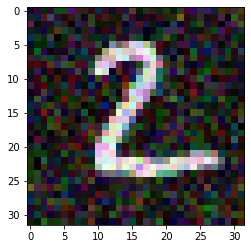



Adversarial image at step 96. L2 error 2297.740335645452 and class label 6.


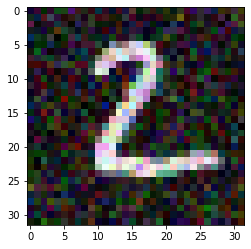



Adversarial image at step 97. L2 error 2287.48267226482 and class label 6.


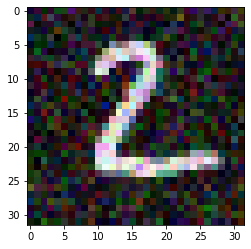



Adversarial image at step 98. L2 error 2280.645985575891 and class label 6.


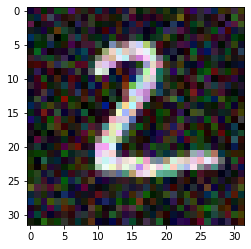



Adversarial image at step 99. L2 error 2273.824070415494 and class label 6.


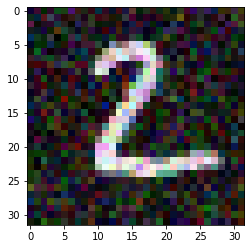



Adversarial image at step 0. L2 error 7909.262128747161 and class label 5.


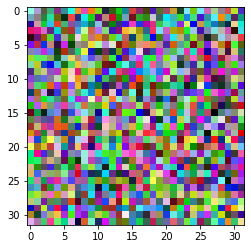



Adversarial image at step 1. L2 error 7830.169520626707 and class label 5.


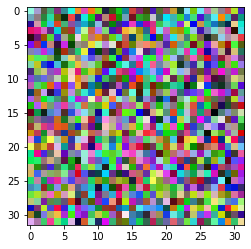



Adversarial image at step 2. L2 error 7712.775680613349 and class label 5.


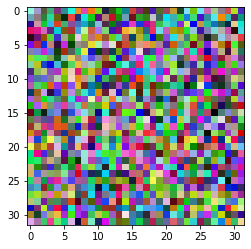



Adversarial image at step 3. L2 error 7539.411614091046 and class label 5.


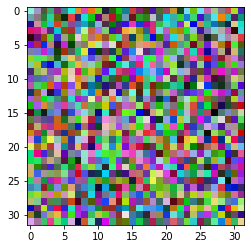



Adversarial image at step 4. L2 error 7369.944354961381 and class label 5.


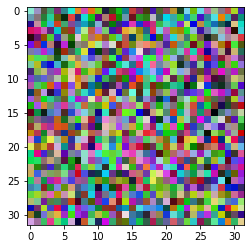



Adversarial image at step 5. L2 error 7320.7865744132605 and class label 5.


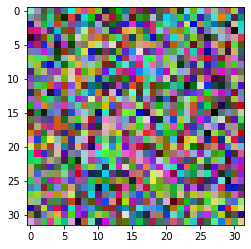



Adversarial image at step 6. L2 error 7288.216805804708 and class label 5.


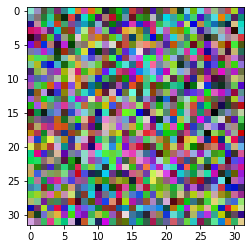



Adversarial image at step 7. L2 error 7266.589107529848 and class label 5.


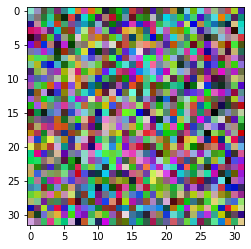



Adversarial image at step 8. L2 error 7245.02330115656 and class label 5.


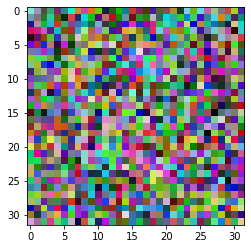



Adversarial image at step 9. L2 error 7212.787606301365 and class label 5.


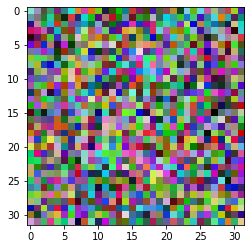



Adversarial image at step 10. L2 error 7180.69548713723 and class label 5.


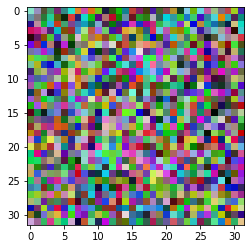



Adversarial image at step 11. L2 error 7166.4774794707755 and class label 5.


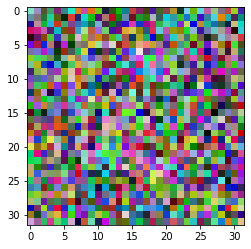



Adversarial image at step 12. L2 error 7145.20990660989 and class label 5.


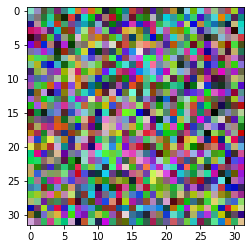



Adversarial image at step 13. L2 error 7113.416595043384 and class label 5.


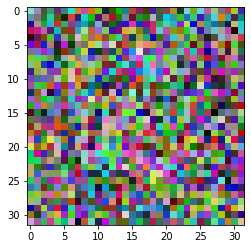



Adversarial image at step 14. L2 error 7065.960217841956 and class label 5.


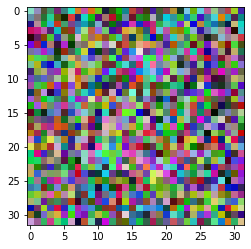



Adversarial image at step 15. L2 error 7018.828579282167 and class label 5.


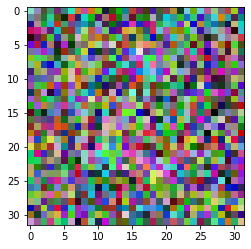



Adversarial image at step 16. L2 error 6987.600170605102 and class label 5.


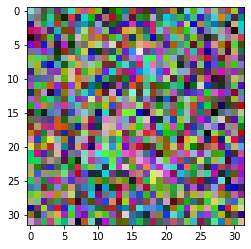



Adversarial image at step 17. L2 error 6956.508826424255 and class label 5.


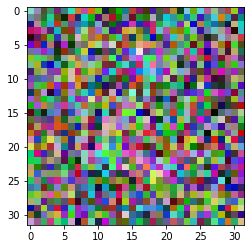



Adversarial image at step 18. L2 error 6925.551607169159 and class label 5.


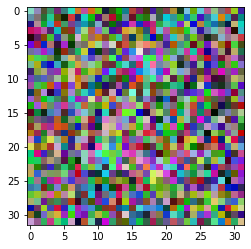



Adversarial image at step 19. L2 error 6894.737584268207 and class label 5.


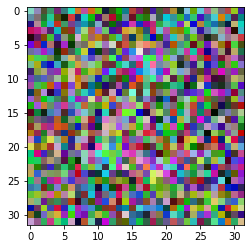



Adversarial image at step 20. L2 error 6864.059535920173 and class label 5.


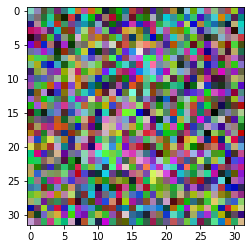



Adversarial image at step 21. L2 error 6843.679497151849 and class label 5.


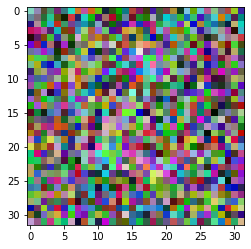



Adversarial image at step 22. L2 error 6823.361911931998 and class label 5.


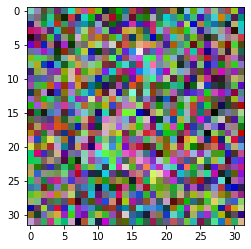



Adversarial image at step 23. L2 error 6792.9726977694145 and class label 5.


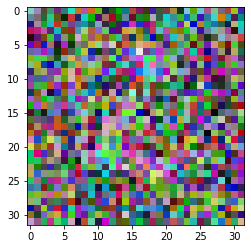



Adversarial image at step 24. L2 error 6762.673219599102 and class label 5.


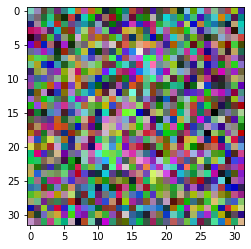



Adversarial image at step 25. L2 error 6717.538930767136 and class label 5.


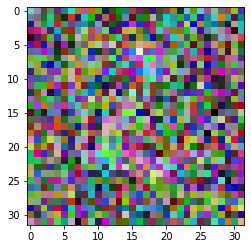



Adversarial image at step 26. L2 error 6672.709904028476 and class label 5.


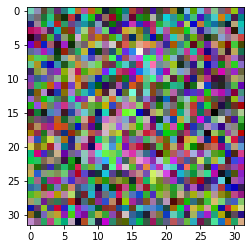



Adversarial image at step 27. L2 error 6628.1761769256955 and class label 5.


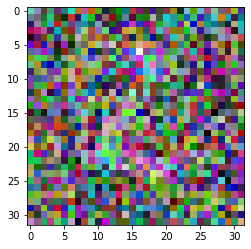



Adversarial image at step 28. L2 error 6583.936798869688 and class label 5.


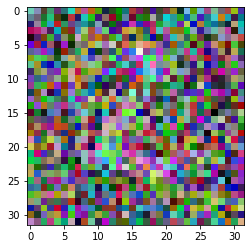



Adversarial image at step 29. L2 error 6518.032014263893 and class label 5.


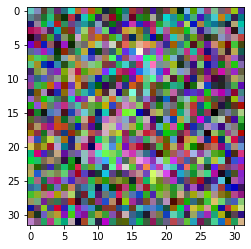



Adversarial image at step 30. L2 error 6420.14237811506 and class label 5.


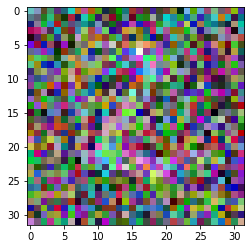



Adversarial image at step 31. L2 error 6355.655318954195 and class label 5.


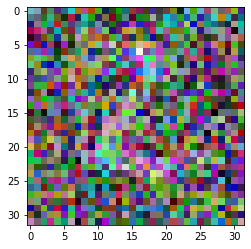



Adversarial image at step 32. L2 error 6312.861707322794 and class label 5.


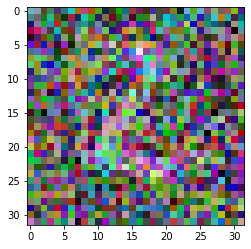



Adversarial image at step 33. L2 error 6249.411297977246 and class label 5.


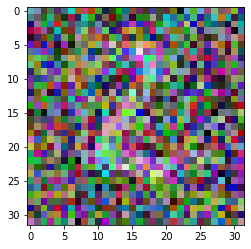



Adversarial image at step 34. L2 error 6155.5021441094095 and class label 5.


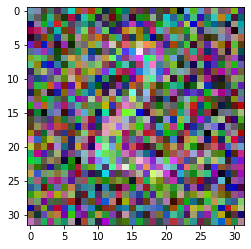



Adversarial image at step 35. L2 error 6063.001160068671 and class label 5.


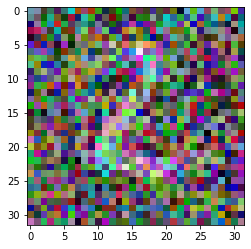



Adversarial image at step 36. L2 error 6035.969293724766 and class label 5.


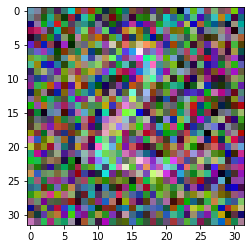



Adversarial image at step 37. L2 error 6033.5876617097665 and class label 5.


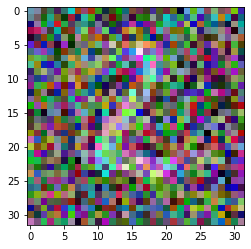



Adversarial image at step 38. L2 error 6030.0384849896955 and class label 5.


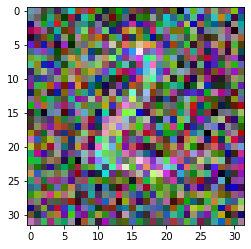



Adversarial image at step 39. L2 error 6024.725502757732 and class label 5.


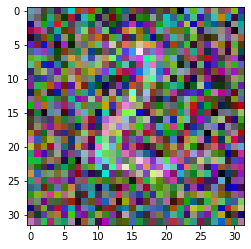



Adversarial image at step 40. L2 error 6023.148188226157 and class label 5.


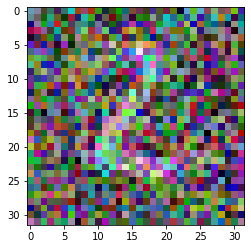



Adversarial image at step 41. L2 error 6020.787406199469 and class label 5.


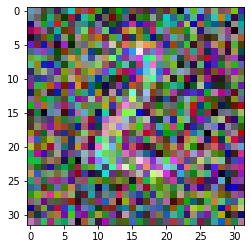



Adversarial image at step 42. L2 error 6017.251158426615 and class label 5.


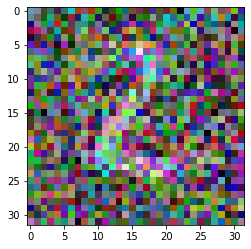



Adversarial image at step 43. L2 error 6011.952291430059 and class label 5.


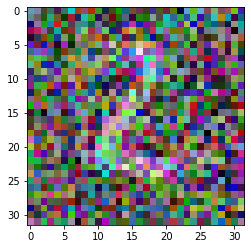



Adversarial image at step 44. L2 error 6006.658194070349 and class label 5.


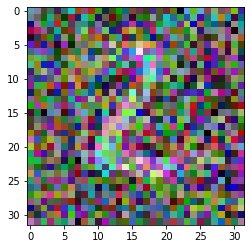



Adversarial image at step 45. L2 error 6001.3686537564445 and class label 5.


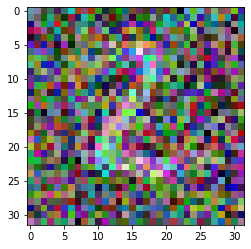



Adversarial image at step 46. L2 error 5996.083781417178 and class label 5.


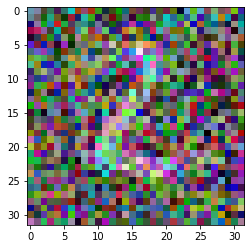



Adversarial image at step 47. L2 error 5994.516470884726 and class label 5.


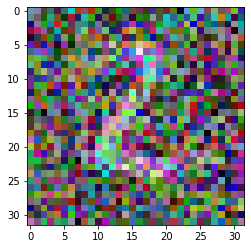



Adversarial image at step 48. L2 error 5992.167763435933 and class label 5.


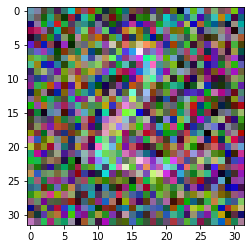



Adversarial image at step 49. L2 error 5988.647608001759 and class label 5.


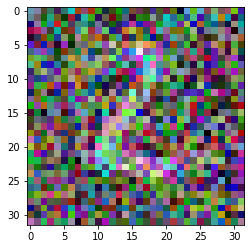



Adversarial image at step 50. L2 error 5985.128580652564 and class label 5.


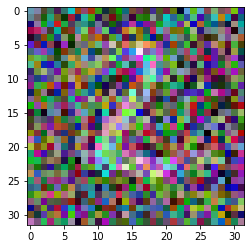



Adversarial image at step 51. L2 error 5979.856932708292 and class label 5.


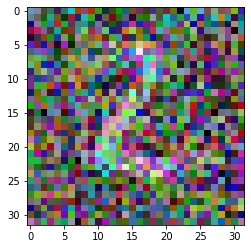



Adversarial image at step 52. L2 error 5971.961197742236 and class label 5.


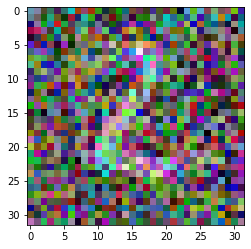



Adversarial image at step 53. L2 error 5970.91889890879 and class label 5.


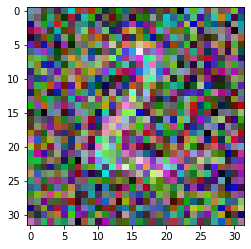



Adversarial image at step 54. L2 error 5969.358381397562 and class label 5.


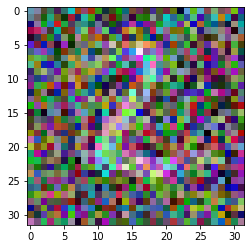



Adversarial image at step 55. L2 error 5967.018795711953 and class label 5.


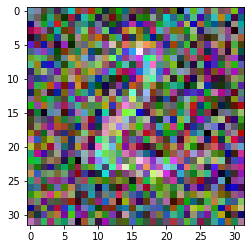



Adversarial image at step 56. L2 error 5964.681055136143 and class label 5.


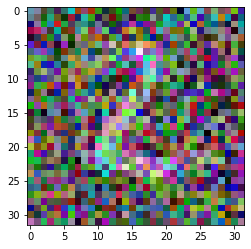



Adversarial image at step 57. L2 error 5961.177735420286 and class label 5.


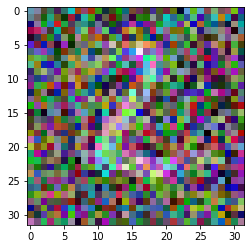



Adversarial image at step 58. L2 error 5957.676467678323 and class label 5.


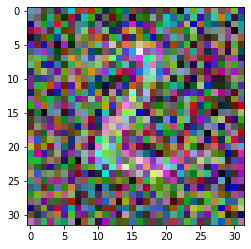



Adversarial image at step 59. L2 error 5952.430248729351 and class label 5.


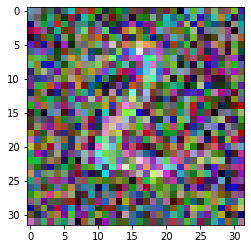



Adversarial image at step 60. L2 error 5944.571958183837 and class label 5.


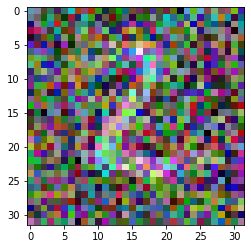



Adversarial image at step 61. L2 error 5939.337199088361 and class label 5.


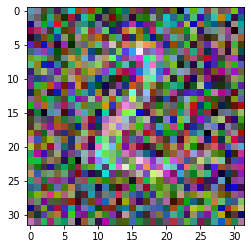



Adversarial image at step 62. L2 error 5931.495934810803 and class label 5.


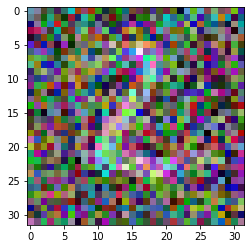



Adversarial image at step 63. L2 error 5926.272894084296 and class label 5.


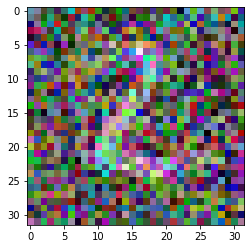



Adversarial image at step 64. L2 error 5918.449076041448 and class label 5.


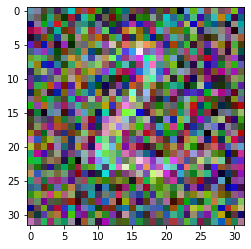



Adversarial image at step 65. L2 error 5913.236664958033 and class label 5.


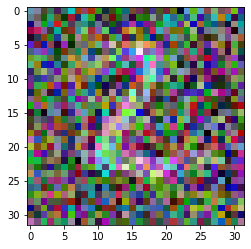



Adversarial image at step 66. L2 error 5905.429089749136 and class label 5.


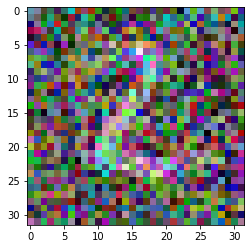



Adversarial image at step 67. L2 error 5900.228635638103 and class label 5.


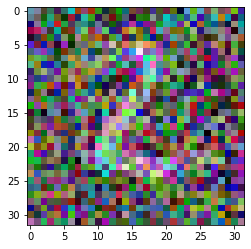



Adversarial image at step 68. L2 error 5895.032199952618 and class label 5.


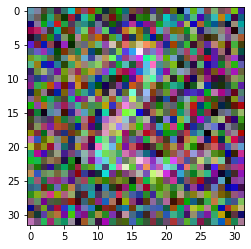



Adversarial image at step 69. L2 error 5891.56914639876 and class label 5.


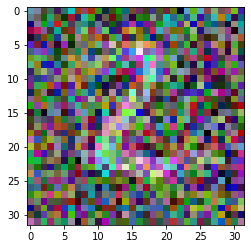



Adversarial image at step 70. L2 error 5888.108458242326 and class label 5.


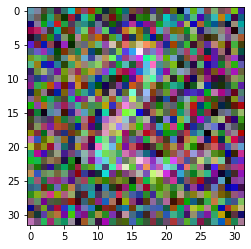



Adversarial image at step 71. L2 error 5882.923554267581 and class label 5.


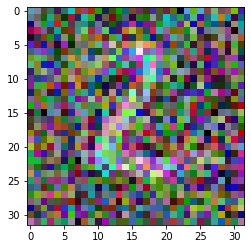



Adversarial image at step 72. L2 error 5879.468127435283 and class label 5.


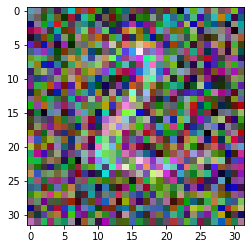



Adversarial image at step 73. L2 error 5876.01493508726 and class label 5.


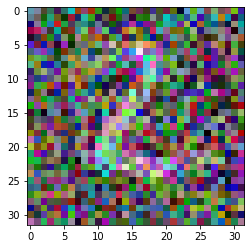



Adversarial image at step 74. L2 error 5872.563757785291 and class label 5.


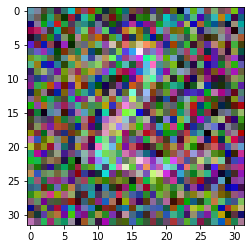



Adversarial image at step 75. L2 error 5869.114506803701 and class label 5.


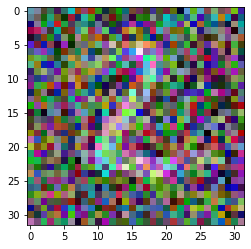



Adversarial image at step 76. L2 error 5865.667257771433 and class label 5.


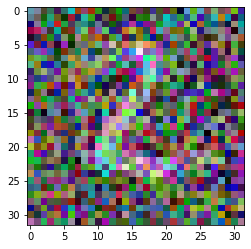



Adversarial image at step 77. L2 error 5862.222008848596 and class label 5.


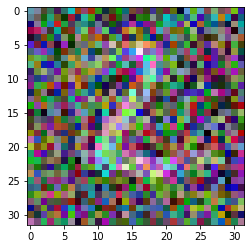



Adversarial image at step 78. L2 error 5859.92543179701 and class label 5.


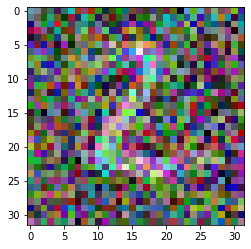



Adversarial image at step 79. L2 error 5856.48363767319 and class label 5.


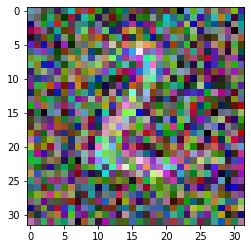



Adversarial image at step 80. L2 error 5851.32666354636 and class label 5.


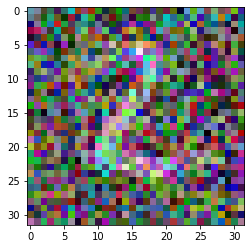



Adversarial image at step 81. L2 error 5846.174047843017 and class label 5.


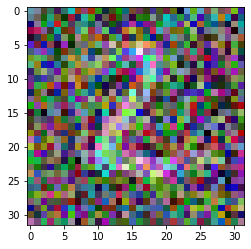



Adversarial image at step 82. L2 error 5841.025848050588 and class label 5.


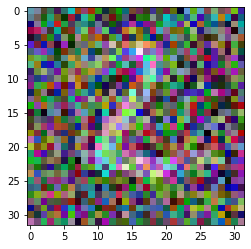



Adversarial image at step 83. L2 error 5837.594965843881 and class label 5.


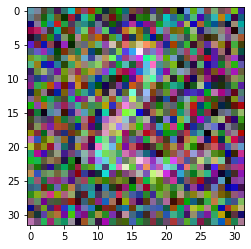



Adversarial image at step 84. L2 error 5832.454613600369 and class label 5.


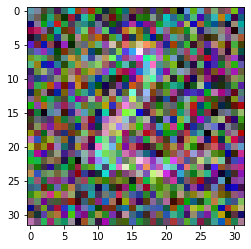



Adversarial image at step 85. L2 error 5827.318580609887 and class label 5.


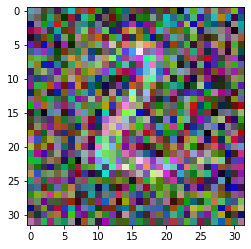



Adversarial image at step 86. L2 error 5822.187092548929 and class label 5.


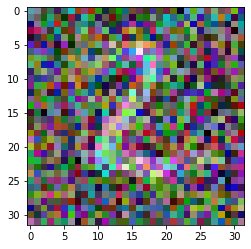



Adversarial image at step 87. L2 error 5817.059863547799 and class label 5.


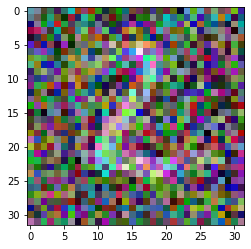



Adversarial image at step 88. L2 error 5816.926003700127 and class label 5.


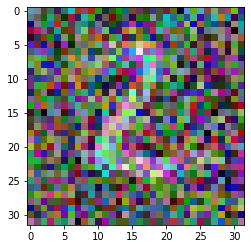



Adversarial image at step 89. L2 error 5816.7252837211645 and class label 5.


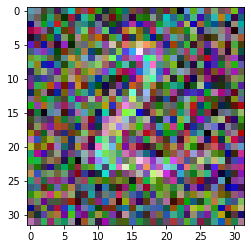



Adversarial image at step 90. L2 error 5816.423981145098 and class label 5.


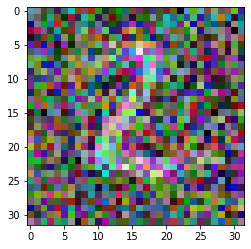



Adversarial image at step 91. L2 error 5815.972720561853 and class label 5.


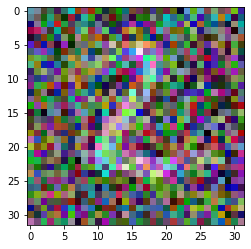



Adversarial image at step 92. L2 error 5815.296447101431 and class label 5.


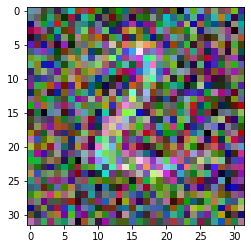



Adversarial image at step 93. L2 error 5814.282717020397 and class label 5.


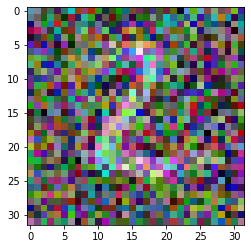



Adversarial image at step 94. L2 error 5812.763308367157 and class label 5.


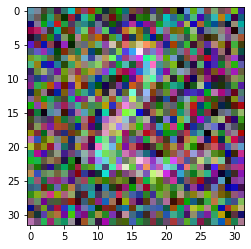



Adversarial image at step 95. L2 error 5810.483442379937 and class label 5.


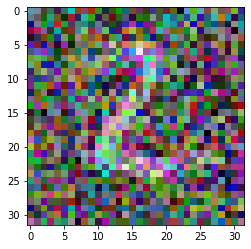



Adversarial image at step 96. L2 error 5807.066502527378 and class label 5.


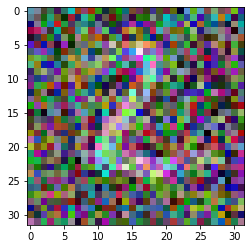



Adversarial image at step 97. L2 error 5801.952133921754 and class label 5.


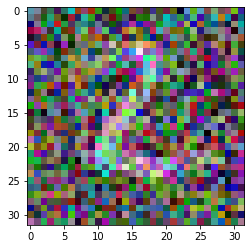



Adversarial image at step 98. L2 error 5796.842015948583 and class label 5.


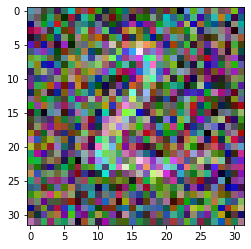



Adversarial image at step 99. L2 error 5791.736098898015 and class label 5.


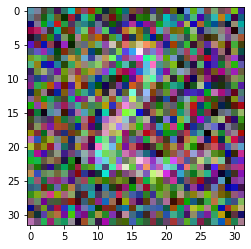

In [4]:
data_set_name='Mnist'
(_,X_test,_,y_test)=pick_data_set(data_set_name)        
if exists(Config.DATA_PATH+'efficiency_adv_trained/black_box'+str(data_set_name))==False:
        model.load_weights(Config.MODELS_PATH+'adversarial_training/Mnist/c=0.h5')
        degree_of_change_without_defense=boundary_attack_run(model,X_test[1])
        model.load_weights(Config.MODELS_PATH+'adversarial_training/Mnist/c=0.9.h5')
        degree_of_change_with_defense=boundary_attack_run(model,X_test[1])
        with open(Config.DATA_PATH+'adversarial_training/black_box'+str(data_set_name), 'wb') as f:
            pickle.Pickler(f).dump(degree_of_change_without_defense)
            pickle.Pickler(f).dump(degree_of_change_with_defense)
else:
    with open(Config.DATA_PATH+'efficiency_adv_trained/black_box'+str(data_set_name), 'rb') as f:
        degree_of_change_without_defense=pickle.Unpickler(f).load()
        degree_of_change_with_defense=pickle.Unpickler(f).load()


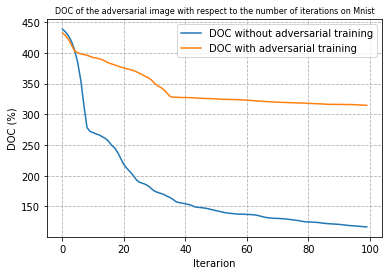

In [6]:
plt.plot(list(degree_of_change_without_defense.keys()),list(degree_of_change_without_defense.values()),label='DOC without adversarial training')
plt.plot(list(degree_of_change_with_defense.keys()),list(degree_of_change_with_defense.values()),label='DOC with adversarial training')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on Mnist', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()

#### Cifar



Adversarial image at step 0. L2 error 6213.491441694869 and class label 6.


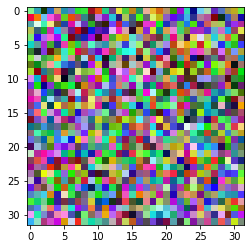



Adversarial image at step 1. L2 error 6151.356531671531 and class label 6.


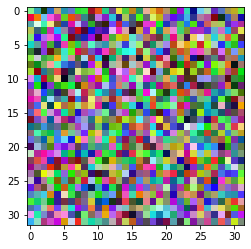



Adversarial image at step 2. L2 error 6059.132298963498 and class label 6.


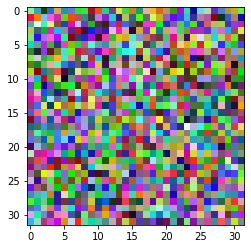



Adversarial image at step 3. L2 error 5922.938055928103 and class label 6.


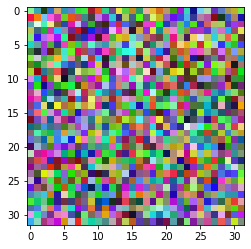



Adversarial image at step 4. L2 error 5723.338401738794 and class label 6.


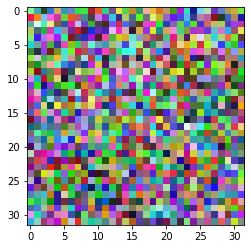



Adversarial image at step 5. L2 error 5434.173054545022 and class label 6.


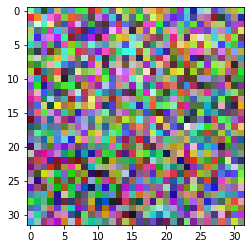



Adversarial image at step 6. L2 error 5022.545581710674 and class label 6.


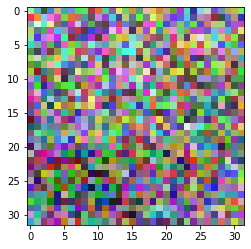



Adversarial image at step 7. L2 error 4853.2886463946825 and class label 6.


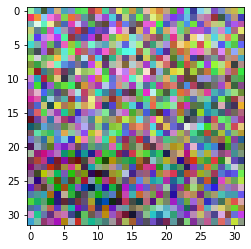



Adversarial image at step 8. L2 error 4780.525493658677 and class label 6.


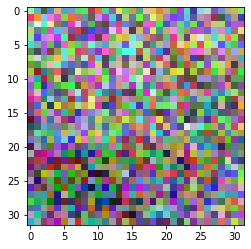



Adversarial image at step 9. L2 error 4732.720102574334 and class label 6.


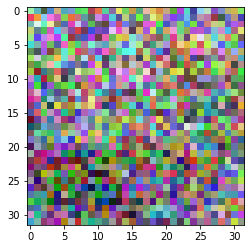



Adversarial image at step 10. L2 error 4685.3891957166625 and class label 6.


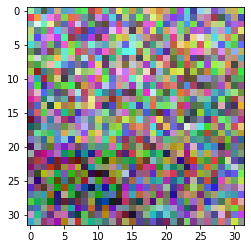



Adversarial image at step 11. L2 error 4654.129095102731 and class label 6.


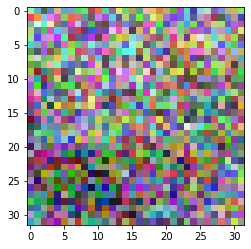



Adversarial image at step 12. L2 error 4622.969709257122 and class label 6.


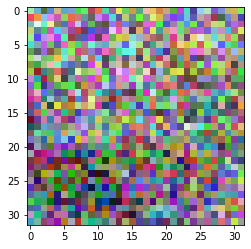



Adversarial image at step 13. L2 error 4576.65692212638 and class label 6.


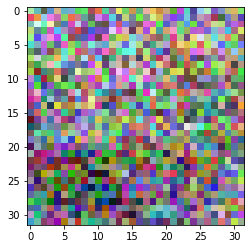



Adversarial image at step 14. L2 error 4507.886982077533 and class label 6.


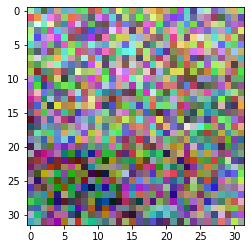



Adversarial image at step 15. L2 error 4440.179565516326 and class label 6.


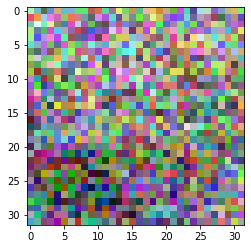



Adversarial image at step 16. L2 error 4373.355810721753 and class label 6.


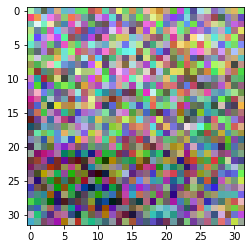



Adversarial image at step 17. L2 error 4307.656119446715 and class label 6.


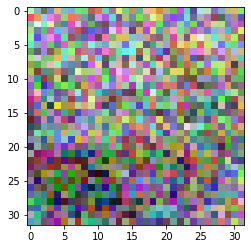



Adversarial image at step 18. L2 error 4264.208213573337 and class label 6.


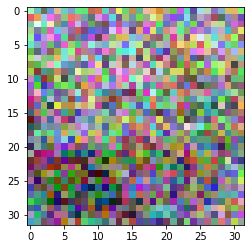



Adversarial image at step 19. L2 error 4199.435625903575 and class label 6.


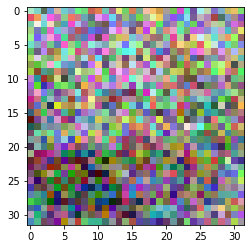



Adversarial image at step 20. L2 error 4104.1643766710795 and class label 6.


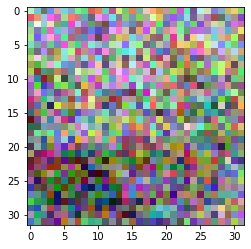



Adversarial image at step 21. L2 error 4040.885167309328 and class label 6.


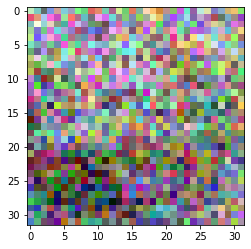



Adversarial image at step 22. L2 error 3978.4899111580644 and class label 6.


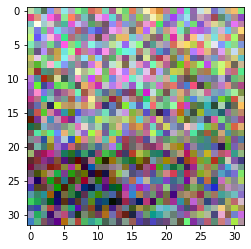



Adversarial image at step 23. L2 error 3887.519000762621 and class label 6.


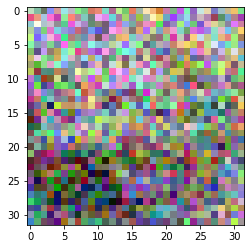



Adversarial image at step 24. L2 error 3827.296855191186 and class label 6.


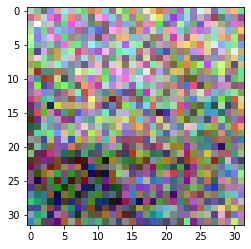



Adversarial image at step 25. L2 error 3767.5393941118377 and class label 6.


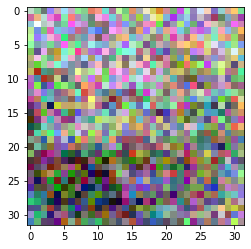



Adversarial image at step 26. L2 error 3726.4265141580895 and class label 6.


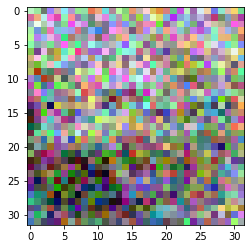



Adversarial image at step 27. L2 error 3668.6270484023753 and class label 6.


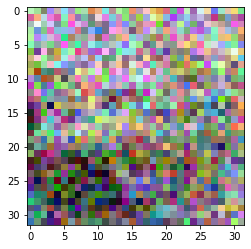



Adversarial image at step 28. L2 error 3611.1988362368857 and class label 6.


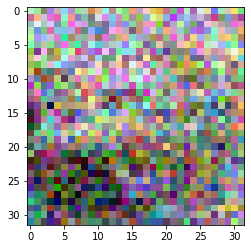



Adversarial image at step 29. L2 error 3591.9575211099605 and class label 6.


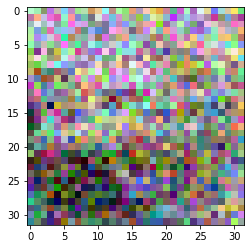



Adversarial image at step 30. L2 error 3573.1908415191006 and class label 6.


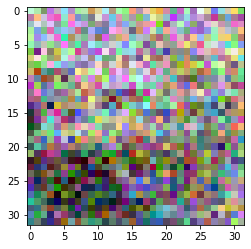



Adversarial image at step 31. L2 error 3556.2339946942798 and class label 6.


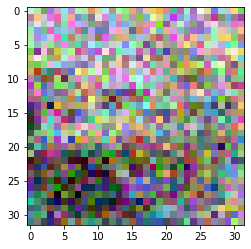



Adversarial image at step 32. L2 error 3539.2137033687554 and class label 6.


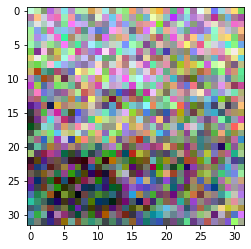



Adversarial image at step 33. L2 error 3514.4260858650764 and class label 6.


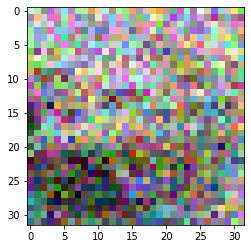



Adversarial image at step 34. L2 error 3498.0185880463523 and class label 6.


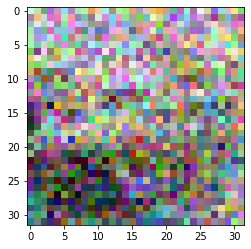



Adversarial image at step 35. L2 error 3474.255293400924 and class label 6.


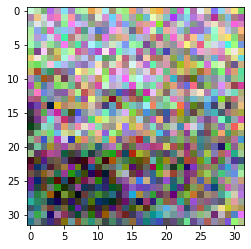



Adversarial image at step 36. L2 error 3449.8370422264807 and class label 6.


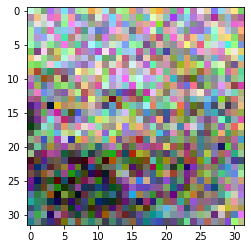



Adversarial image at step 37. L2 error 3414.516468225198 and class label 6.


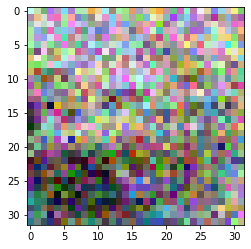



Adversarial image at step 38. L2 error 3379.5698665903283 and class label 6.


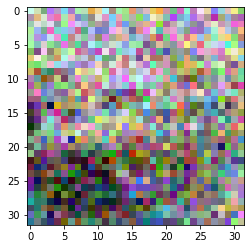



Adversarial image at step 39. L2 error 3345.4940168853323 and class label 6.


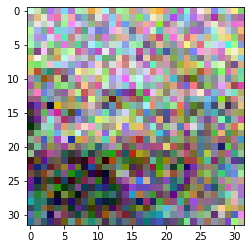



Adversarial image at step 40. L2 error 3322.9802115240436 and class label 6.


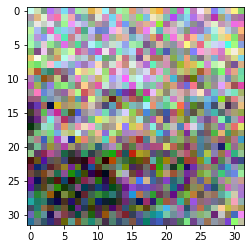



Adversarial image at step 41. L2 error 3300.554375101896 and class label 6.


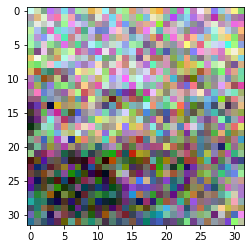



Adversarial image at step 42. L2 error 3278.3202500327084 and class label 6.


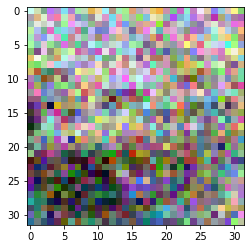



Adversarial image at step 43. L2 error 3263.493375046456 and class label 6.


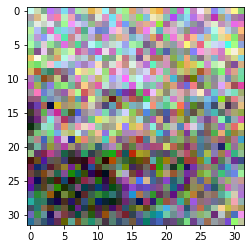



Adversarial image at step 44. L2 error 3248.8165667359467 and class label 6.


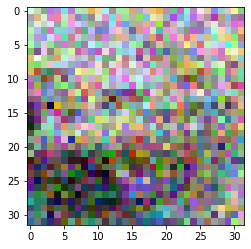



Adversarial image at step 45. L2 error 3234.2750573246317 and class label 6.


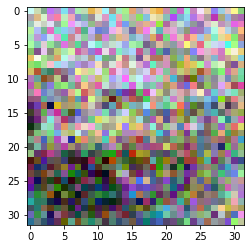



Adversarial image at step 46. L2 error 3219.7151387672952 and class label 6.


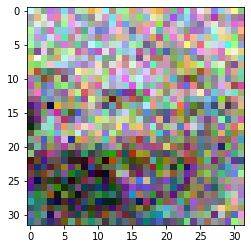



Adversarial image at step 47. L2 error 3213.243946857926 and class label 6.


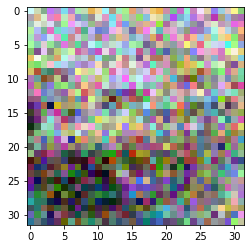



Adversarial image at step 48. L2 error 3208.915682235375 and class label 6.


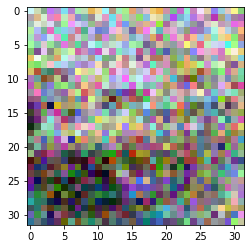



Adversarial image at step 49. L2 error 3202.536779405347 and class label 6.


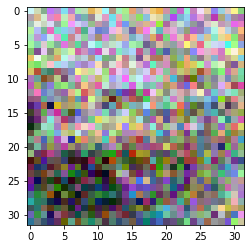



Adversarial image at step 50. L2 error 3196.140493459389 and class label 6.


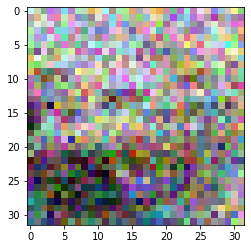



Adversarial image at step 51. L2 error 3186.4870485948163 and class label 6.


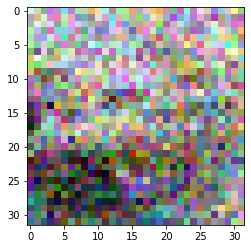



Adversarial image at step 52. L2 error 3172.150243531054 and class label 6.


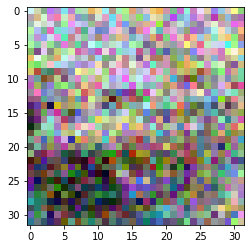



Adversarial image at step 53. L2 error 3150.926376517218 and class label 6.


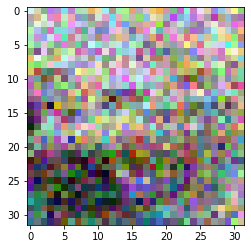



Adversarial image at step 54. L2 error 3136.801362857768 and class label 6.


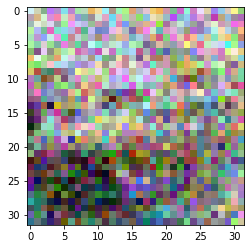



Adversarial image at step 55. L2 error 3127.2508355420136 and class label 6.


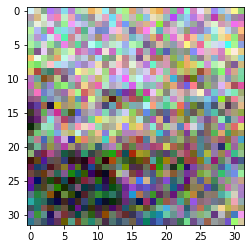



Adversarial image at step 56. L2 error 3113.215988772734 and class label 6.


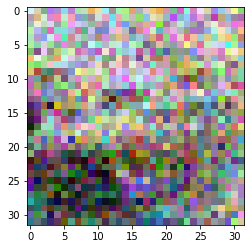



Adversarial image at step 57. L2 error 3103.914748781398 and class label 6.


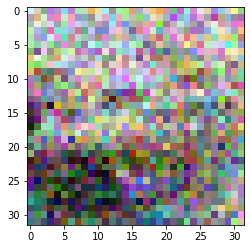



Adversarial image at step 58. L2 error 3094.5905882624907 and class label 6.


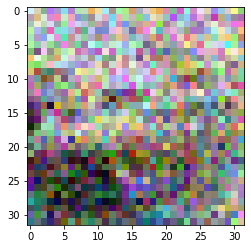



Adversarial image at step 59. L2 error 3085.2998609048714 and class label 6.


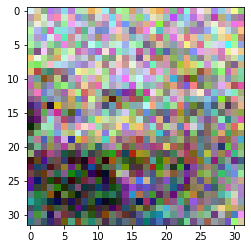



Adversarial image at step 60. L2 error 3071.4753879602463 and class label 6.


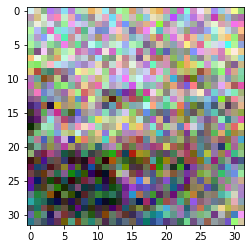



Adversarial image at step 61. L2 error 3057.757763895883 and class label 6.


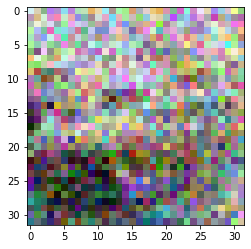



Adversarial image at step 62. L2 error 3043.9454209800983 and class label 6.


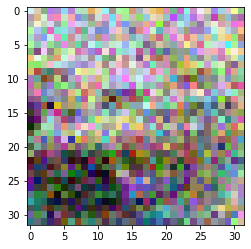



Adversarial image at step 63. L2 error 3030.2809676485776 and class label 6.


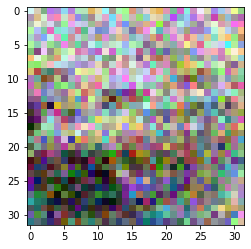



Adversarial image at step 64. L2 error 3009.4948048048136 and class label 6.


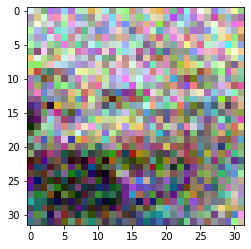



Adversarial image at step 65. L2 error 2979.0832454231345 and class label 6.


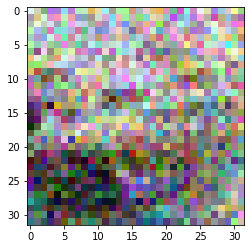



Adversarial image at step 66. L2 error 2976.5778882177333 and class label 6.


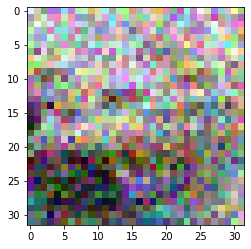



Adversarial image at step 67. L2 error 2973.3909228815473 and class label 6.


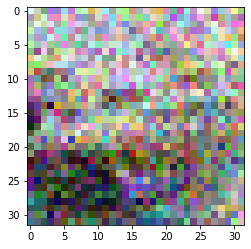



Adversarial image at step 68. L2 error 2969.1098660743755 and class label 6.


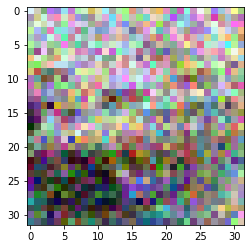



Adversarial image at step 69. L2 error 2962.892869158694 and class label 6.


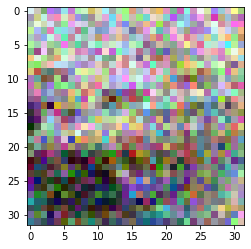



Adversarial image at step 70. L2 error 2953.3107858234234 and class label 6.


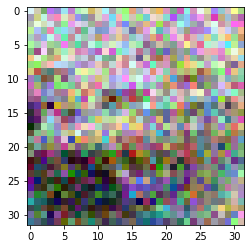



Adversarial image at step 71. L2 error 2938.148238628182 and class label 6.


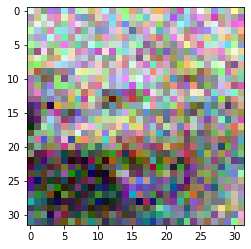



Adversarial image at step 72. L2 error 2918.304291262589 and class label 6.


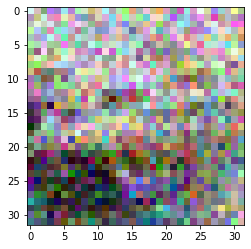



Adversarial image at step 73. L2 error 2898.7827600060446 and class label 6.


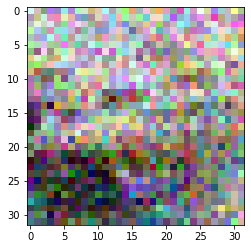



Adversarial image at step 74. L2 error 2885.760253945232 and class label 6.


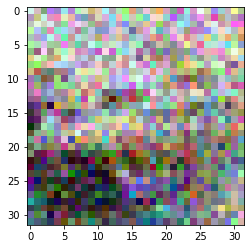



Adversarial image at step 75. L2 error 2879.93171875441 and class label 6.


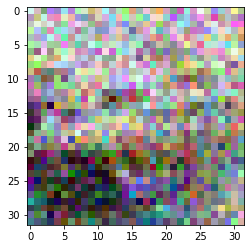



Adversarial image at step 76. L2 error 2874.128317512928 and class label 6.


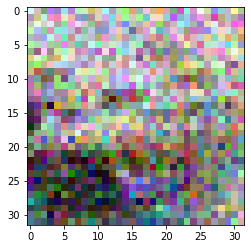



Adversarial image at step 77. L2 error 2865.448049976771 and class label 6.


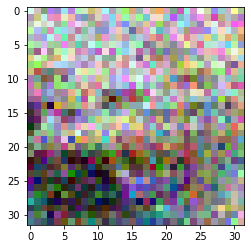



Adversarial image at step 78. L2 error 2856.8338914967403 and class label 6.


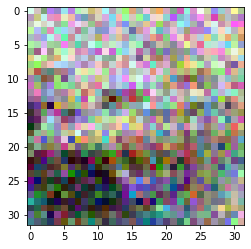



Adversarial image at step 79. L2 error 2844.05981216643 and class label 6.


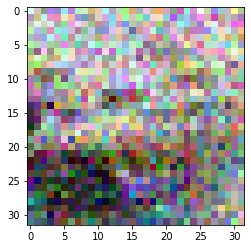



Adversarial image at step 80. L2 error 2835.5233900266344 and class label 6.


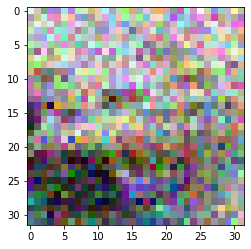



Adversarial image at step 81. L2 error 2822.7594971241315 and class label 6.


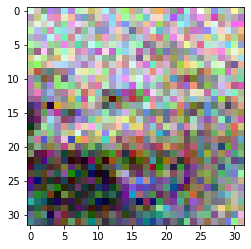



Adversarial image at step 82. L2 error 2803.642992211993 and class label 6.


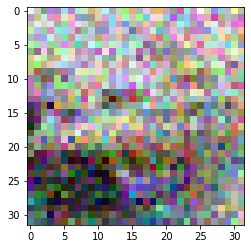



Adversarial image at step 83. L2 error 2784.4542557490163 and class label 6.


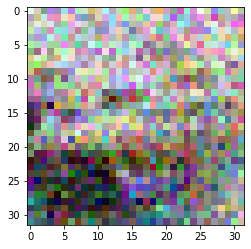



Adversarial image at step 84. L2 error 2765.405765436602 and class label 6.


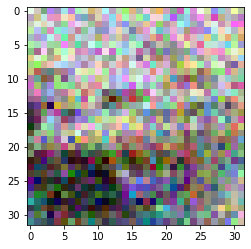



Adversarial image at step 85. L2 error 2746.579685065136 and class label 6.


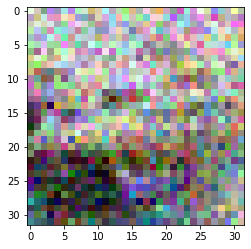



Adversarial image at step 86. L2 error 2733.9280133435773 and class label 6.


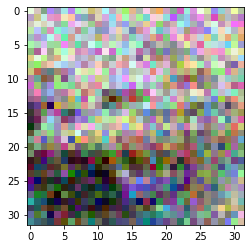



Adversarial image at step 87. L2 error 2715.2425857379553 and class label 6.


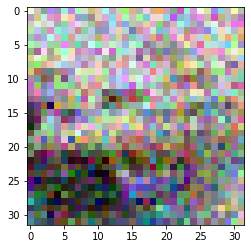



Adversarial image at step 88. L2 error 2696.372468048646 and class label 6.


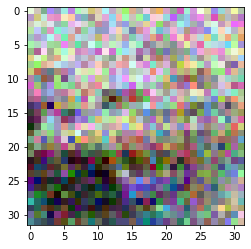



Adversarial image at step 89. L2 error 2678.004925535196 and class label 6.


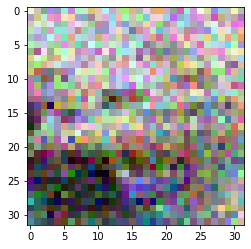



Adversarial image at step 90. L2 error 2665.7029292147267 and class label 6.


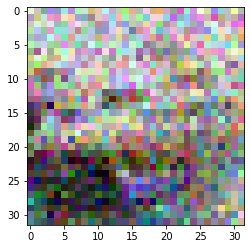



Adversarial image at step 91. L2 error 2653.51245470095 and class label 6.


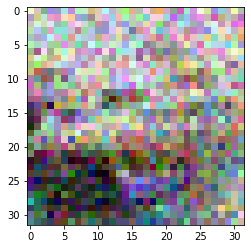



Adversarial image at step 92. L2 error 2635.520958379562 and class label 6.


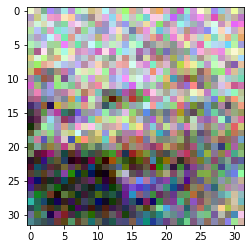



Adversarial image at step 93. L2 error 2617.605847697074 and class label 6.


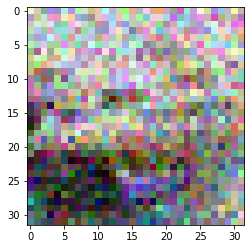



Adversarial image at step 94. L2 error 2615.168239076758 and class label 6.


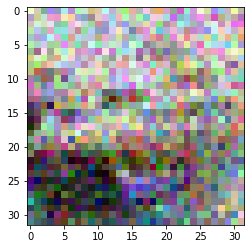



Adversarial image at step 95. L2 error 2612.7527169099203 and class label 6.


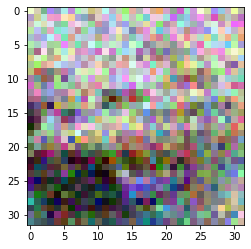



Adversarial image at step 96. L2 error 2609.2624634389645 and class label 6.


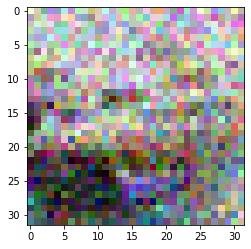



Adversarial image at step 97. L2 error 2603.93046604955 and class label 6.


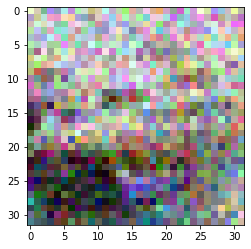



Adversarial image at step 98. L2 error 2596.0728990995567 and class label 6.


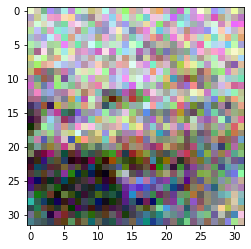



Adversarial image at step 99. L2 error 2584.0696207489273 and class label 6.


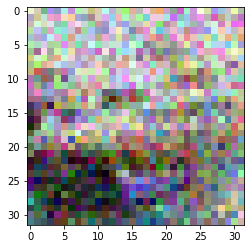



Adversarial image at step 0. L2 error 6212.378509151563 and class label 6.


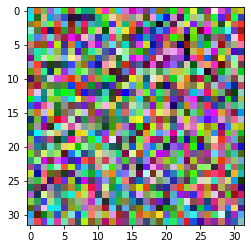



Adversarial image at step 1. L2 error 6150.24598715182 and class label 6.


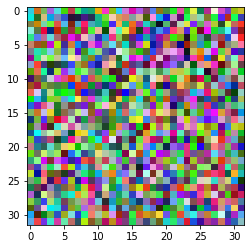



Adversarial image at step 2. L2 error 6058.038397042926 and class label 6.


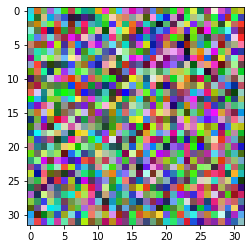



Adversarial image at step 3. L2 error 5921.868745136188 and class label 6.


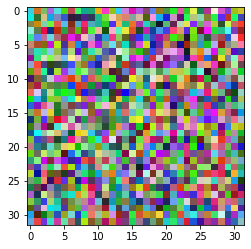



Adversarial image at step 4. L2 error 5722.305161646015 and class label 6.


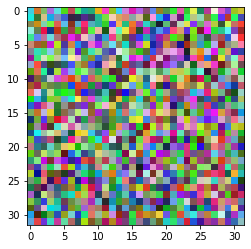



Adversarial image at step 5. L2 error 5433.192088805948 and class label 6.


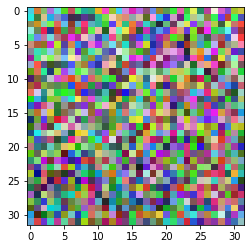



Adversarial image at step 6. L2 error 5021.638983488059 and class label 6.


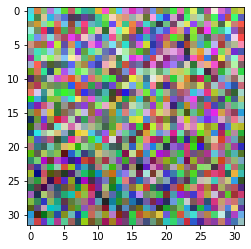



Adversarial image at step 7. L2 error 4451.355749021806 and class label 6.


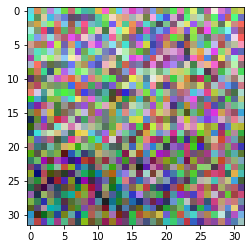



Adversarial image at step 8. L2 error 3693.4564646617387 and class label 6.


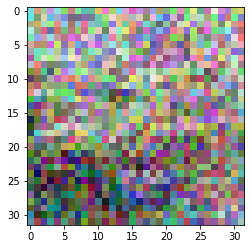



Adversarial image at step 9. L2 error 3274.0085617490367 and class label 6.


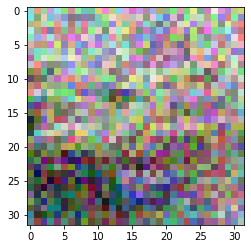



Adversarial image at step 10. L2 error 3108.5929229714707 and class label 6.


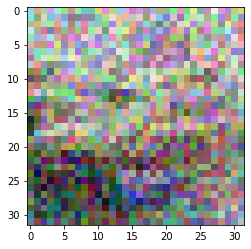



Adversarial image at step 11. L2 error 2951.531927579484 and class label 6.


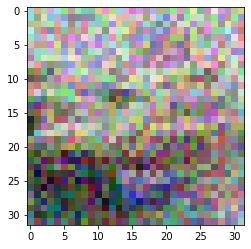



Adversarial image at step 12. L2 error 2885.1887104805664 and class label 6.


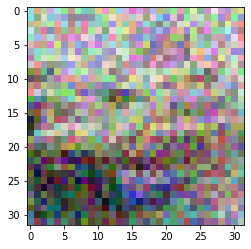



Adversarial image at step 13. L2 error 2820.3339021653182 and class label 6.


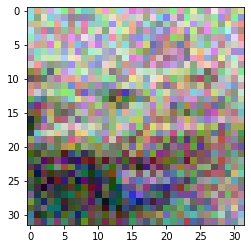



Adversarial image at step 14. L2 error 2756.904255349336 and class label 6.


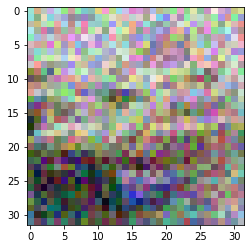



Adversarial image at step 15. L2 error 2663.7413680435147 and class label 6.


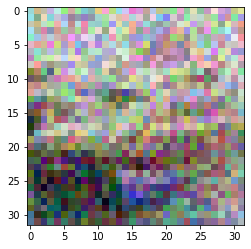



Adversarial image at step 16. L2 error 2528.488068962525 and class label 6.


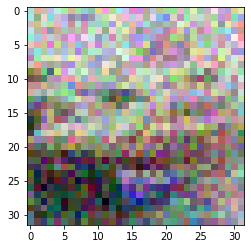



Adversarial image at step 17. L2 error 2399.3143830563395 and class label 6.


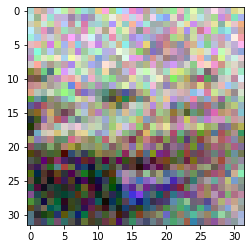



Adversarial image at step 18. L2 error 2317.0916930663075 and class label 6.


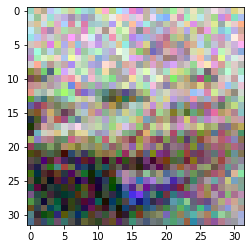



Adversarial image at step 19. L2 error 2292.5276306116702 and class label 6.


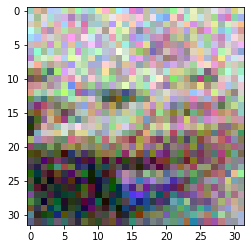



Adversarial image at step 20. L2 error 2257.6201282418265 and class label 6.


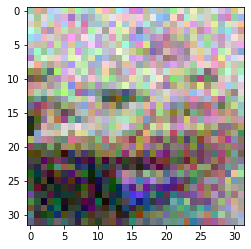



Adversarial image at step 21. L2 error 2222.8849993699846 and class label 6.


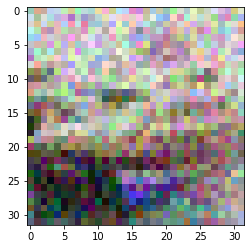



Adversarial image at step 22. L2 error 2171.323897530985 and class label 6.


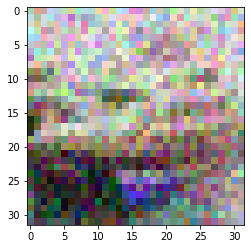



Adversarial image at step 23. L2 error 2096.615793933676 and class label 6.


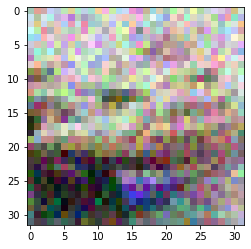



Adversarial image at step 24. L2 error 2045.9003890283898 and class label 6.


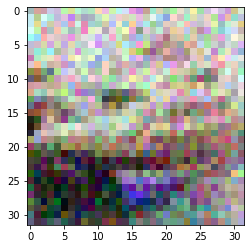



Adversarial image at step 25. L2 error 1998.036098865036 and class label 6.


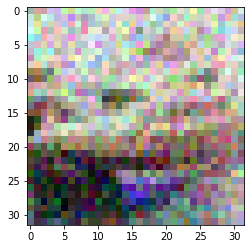



Adversarial image at step 26. L2 error 1951.3759580309347 and class label 6.


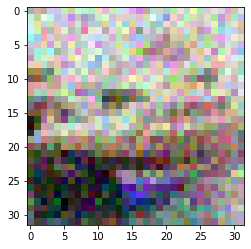



Adversarial image at step 27. L2 error 1880.9194462068242 and class label 6.


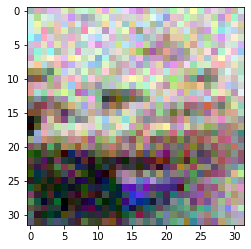



Adversarial image at step 28. L2 error 1811.6281523093294 and class label 6.


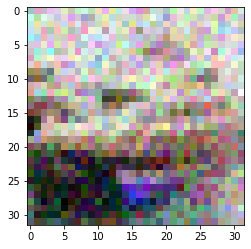



Adversarial image at step 29. L2 error 1746.5281047176977 and class label 6.


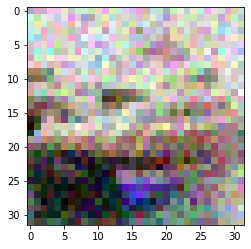



Adversarial image at step 30. L2 error 1706.2047720708147 and class label 6.


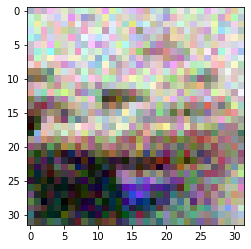



Adversarial image at step 31. L2 error 1680.1587507454465 and class label 6.


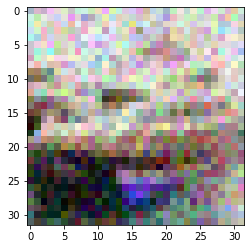



Adversarial image at step 32. L2 error 1662.6460985649285 and class label 6.


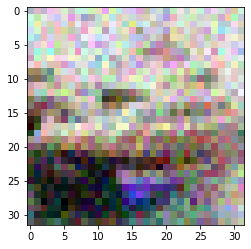



Adversarial image at step 33. L2 error 1644.8096752835 and class label 6.


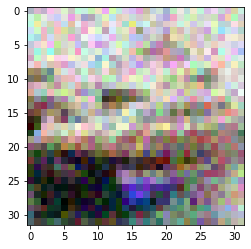



Adversarial image at step 34. L2 error 1619.1841197552621 and class label 6.


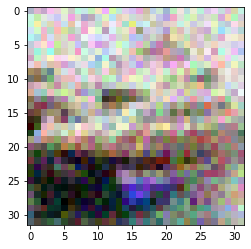



Adversarial image at step 35. L2 error 1615.7940444089 and class label 6.


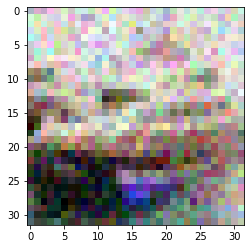



Adversarial image at step 36. L2 error 1612.3369122422018 and class label 6.


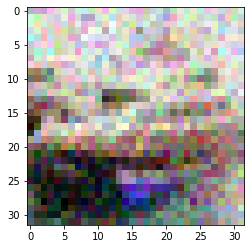



Adversarial image at step 37. L2 error 1607.9519152929504 and class label 6.


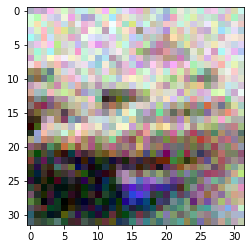



Adversarial image at step 38. L2 error 1602.3726014829188 and class label 6.


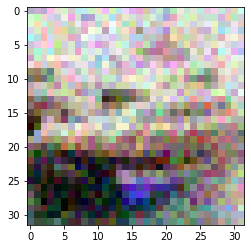



Adversarial image at step 39. L2 error 1594.2892811392626 and class label 6.


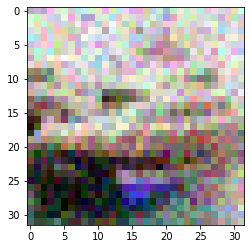



Adversarial image at step 40. L2 error 1582.613644047339 and class label 6.


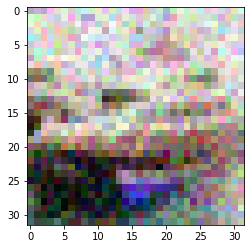



Adversarial image at step 41. L2 error 1565.6581366401667 and class label 6.


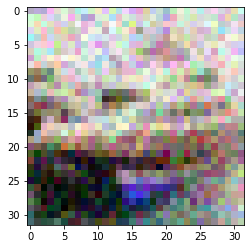



Adversarial image at step 42. L2 error 1563.0373448748107 and class label 6.


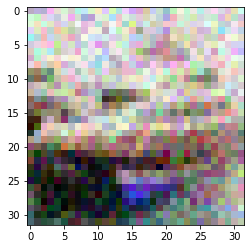



Adversarial image at step 43. L2 error 1560.4008647233693 and class label 6.


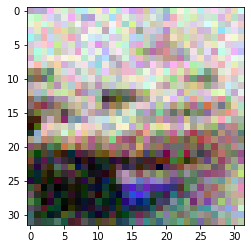



Adversarial image at step 44. L2 error 1556.9013415551603 and class label 6.


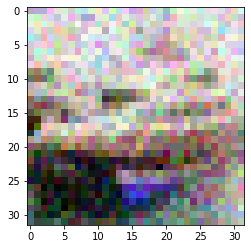



Adversarial image at step 45. L2 error 1551.918813332635 and class label 6.


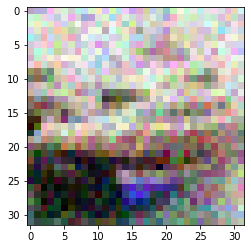



Adversarial image at step 46. L2 error 1543.9623249748079 and class label 6.


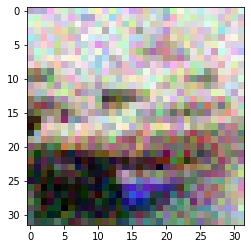



Adversarial image at step 47. L2 error 1533.0349437970376 and class label 6.


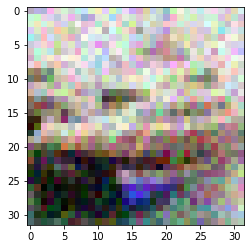



Adversarial image at step 48. L2 error 1517.0406019961379 and class label 6.


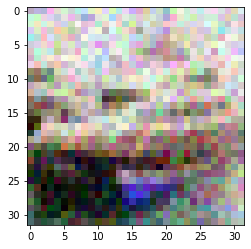



Adversarial image at step 49. L2 error 1501.2024661041312 and class label 6.


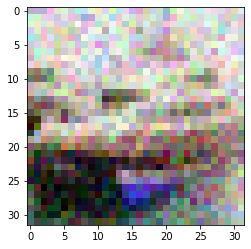



Adversarial image at step 50. L2 error 1485.4194480146173 and class label 6.


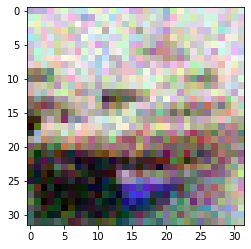



Adversarial image at step 51. L2 error 1475.2273916180388 and class label 6.


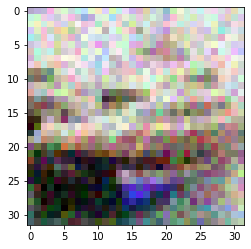



Adversarial image at step 52. L2 error 1465.2913152291073 and class label 6.


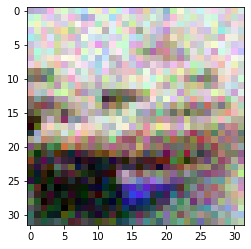



Adversarial image at step 53. L2 error 1450.4525971056387 and class label 6.


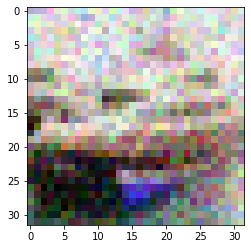



Adversarial image at step 54. L2 error 1440.5817988640158 and class label 6.


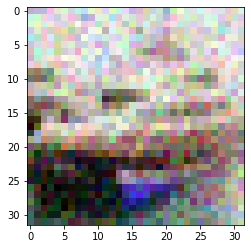



Adversarial image at step 55. L2 error 1426.036467327626 and class label 6.


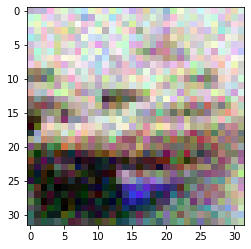



Adversarial image at step 56. L2 error 1419.5055838269623 and class label 6.


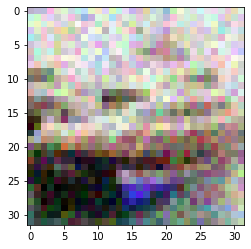



Adversarial image at step 57. L2 error 1409.8296606913384 and class label 6.


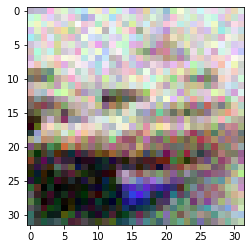



Adversarial image at step 58. L2 error 1400.297561135991 and class label 6.


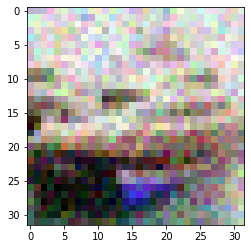



Adversarial image at step 59. L2 error 1390.8109931924428 and class label 6.


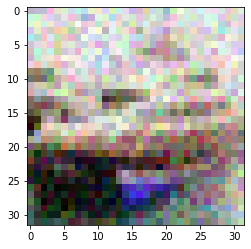



Adversarial image at step 60. L2 error 1381.4237187665994 and class label 6.


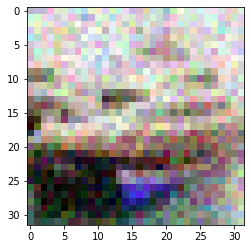



Adversarial image at step 61. L2 error 1372.070449125881 and class label 6.


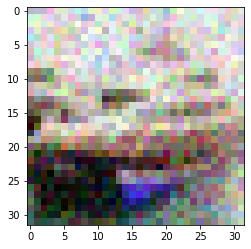



Adversarial image at step 62. L2 error 1358.1204330291782 and class label 6.


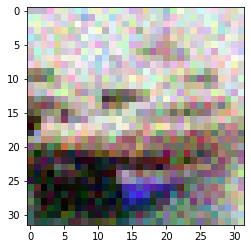



Adversarial image at step 63. L2 error 1356.1908000965095 and class label 6.


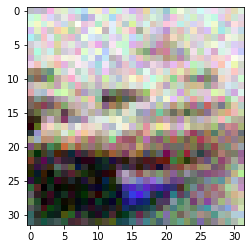



Adversarial image at step 64. L2 error 1354.3289120680383 and class label 6.


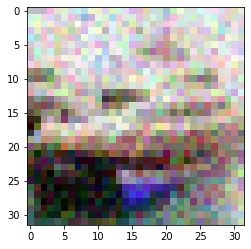



Adversarial image at step 65. L2 error 1351.5879506593258 and class label 6.


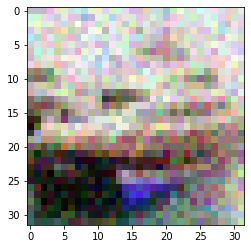



Adversarial image at step 66. L2 error 1347.5371664881463 and class label 6.


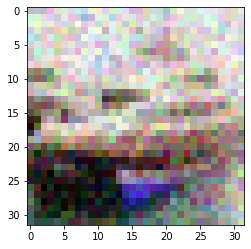



Adversarial image at step 67. L2 error 1341.476347901303 and class label 6.


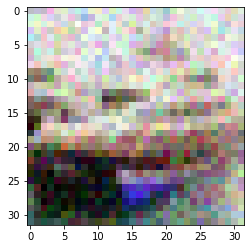



Adversarial image at step 68. L2 error 1335.4700860360308 and class label 6.


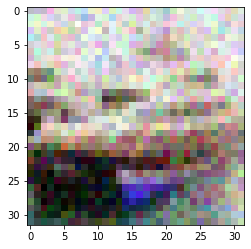



Adversarial image at step 69. L2 error 1329.4319326725383 and class label 6.


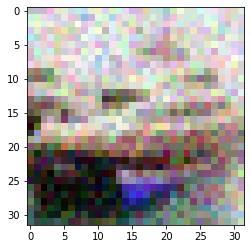



Adversarial image at step 70. L2 error 1323.450323826777 and class label 6.


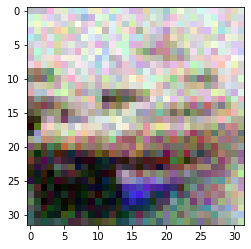



Adversarial image at step 71. L2 error 1317.5309507200438 and class label 6.


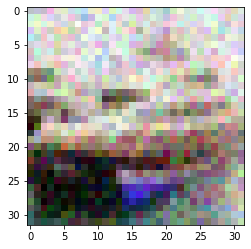



Adversarial image at step 72. L2 error 1308.71532267827 and class label 6.


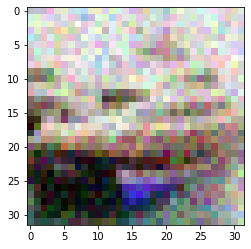



Adversarial image at step 73. L2 error 1299.9501919718969 and class label 6.


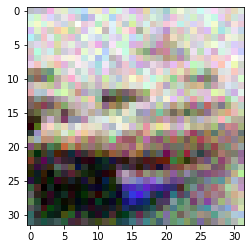



Adversarial image at step 74. L2 error 1294.1190580071905 and class label 6.


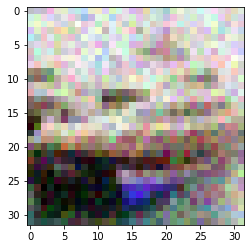



Adversarial image at step 75. L2 error 1288.3040152305923 and class label 6.


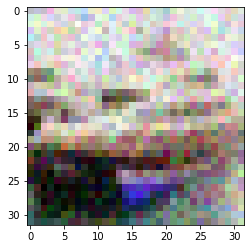



Adversarial image at step 76. L2 error 1282.5464615641547 and class label 6.


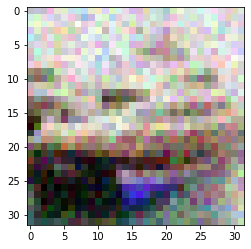



Adversarial image at step 77. L2 error 1278.6178478736779 and class label 6.


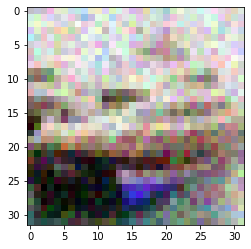



Adversarial image at step 78. L2 error 1274.796127899144 and class label 6.


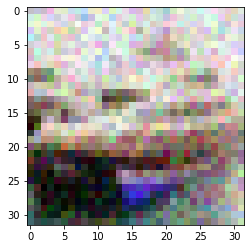



Adversarial image at step 79. L2 error 1272.222773455762 and class label 6.


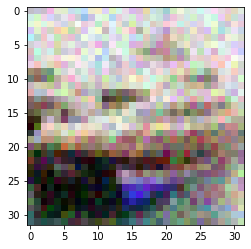



Adversarial image at step 80. L2 error 1269.6509674571591 and class label 6.


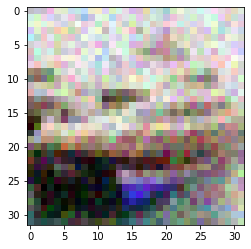



Adversarial image at step 81. L2 error 1265.7997775223416 and class label 6.


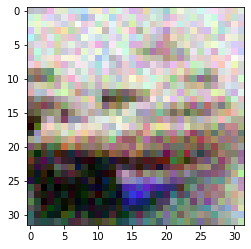



Adversarial image at step 82. L2 error 1261.9687446483572 and class label 6.


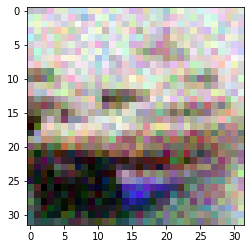



Adversarial image at step 83. L2 error 1258.1878079820929 and class label 6.


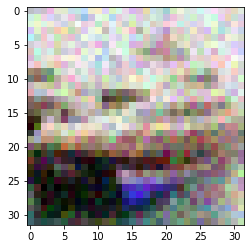



Adversarial image at step 84. L2 error 1254.4273099079314 and class label 6.


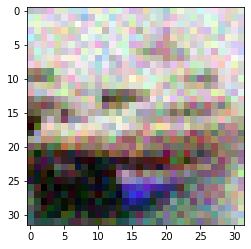



Adversarial image at step 85. L2 error 1251.9356816695836 and class label 6.


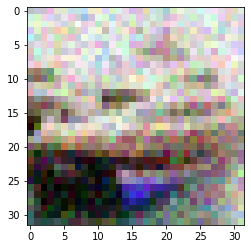



Adversarial image at step 86. L2 error 1248.2148957085258 and class label 6.


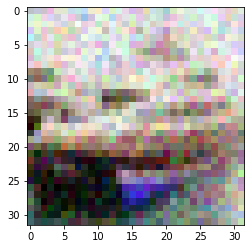



Adversarial image at step 87. L2 error 1244.5055663809164 and class label 6.


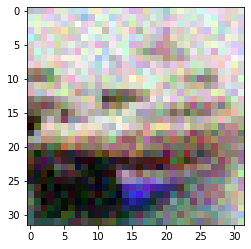



Adversarial image at step 88. L2 error 1242.0352390979192 and class label 6.


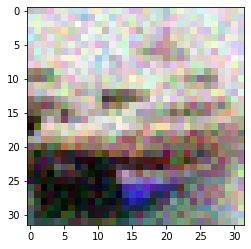



Adversarial image at step 89. L2 error 1239.5500714783734 and class label 6.


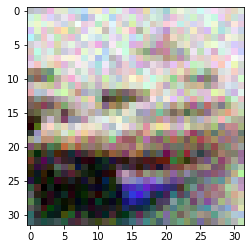



Adversarial image at step 90. L2 error 1237.8954556529625 and class label 6.


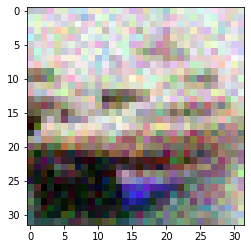



Adversarial image at step 91. L2 error 1235.4420325277795 and class label 6.


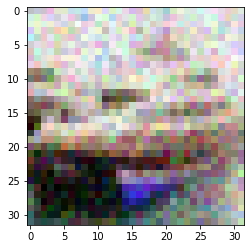



Adversarial image at step 92. L2 error 1233.7991874367572 and class label 6.


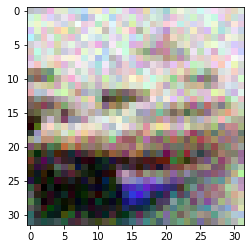



Adversarial image at step 93. L2 error 1232.1681791167957 and class label 6.


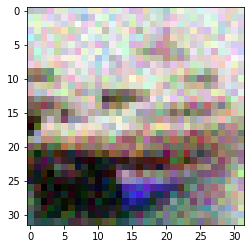



Adversarial image at step 94. L2 error 1231.0670905560023 and class label 6.


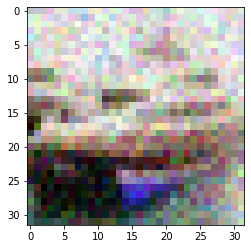



Adversarial image at step 95. L2 error 1229.4304111888005 and class label 6.


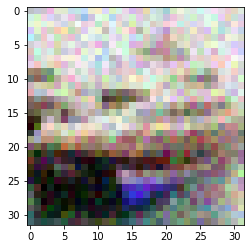



Adversarial image at step 96. L2 error 1227.7977235213912 and class label 6.


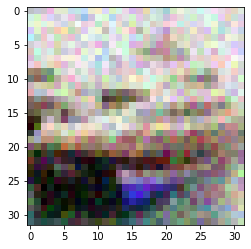



Adversarial image at step 97. L2 error 1225.3535010751787 and class label 6.


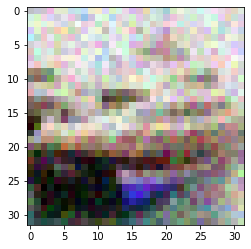



Adversarial image at step 98. L2 error 1221.707565115985 and class label 6.


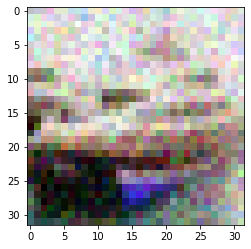



Adversarial image at step 99. L2 error 1219.2635183594052 and class label 6.


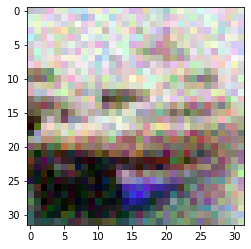

In [7]:
data_set_name='Cifar'
(_,X_test,_,y_test)=pick_data_set(data_set_name)        
if exists(Config.DATA_PATH+'efficiency_adv_trained/black_box'+str(data_set_name))==False:
        model.load_weights(Config.MODELS_PATH+'adversarial_training/Cifar/c=0.h5')
        degree_of_change_without_defense=boundary_attack_run(model,X_test[1])
        model.load_weights(Config.MODELS_PATH+'adversarial_training/Cifar/c=0.9.h5')
        degree_of_change_with_defense=boundary_attack_run(model,X_test[1])
        with open(Config.DATA_PATH+'efficiency_adv_trained/black_box'+str(data_set_name), 'wb') as f:
            pickle.Pickler(f).dump(degree_of_change_without_defense)
            pickle.Pickler(f).dump(degree_of_change_with_defense)
else:
    with open(Config.DATA_PATH+'efficiency_adv_trained/black_box'+str(data_set_name), 'rb') as f:
        degree_of_change_without_defense=pickle.Unpickler(f).load()
        degree_of_change_with_defense=pickle.Unpickler(f).load()

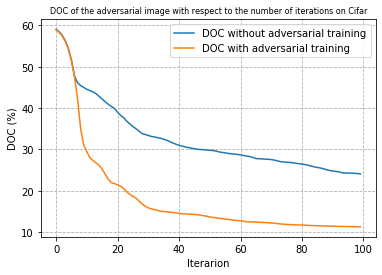

In [8]:
plt.plot(list(degree_of_change_without_defense.keys()),list(degree_of_change_without_defense.values()),label='DOC without adversarial training')
plt.plot(list(degree_of_change_with_defense.keys()),list(degree_of_change_with_defense.values()),label='DOC with adversarial training')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on Cifar', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()